## Comparing one parameter PH and two-parameter PH

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import math
from gtda.homology import VietorisRipsPersistence
import gudhi
import ripser
from persim import plot_diagrams
from compute_rank_function_from_barcode import rank_function
import matplotlib.pyplot as plt

### IDEA: Generate circles with outliers i.e. points in the middle of the circle or far from the circle and see how the one-parameter PH computations fares

In [3]:
# function to generate n pts on the circle of radius r around centre (x,y) normally set to be (0,0)
def sample_circle(r, n, centre = [0,0]):
    theta = np.random.rand(n)*2*np.pi
    x = centre[0] + r * np.cos(theta)
    y = centre[1] + r * np.sin(theta)
    return np.transpose(np.array([x,y])) # output is a nx2 matrix

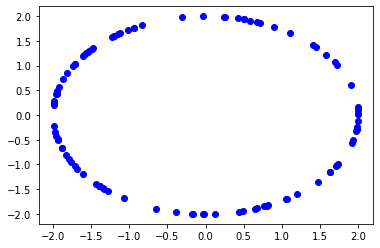

In [37]:
trial = sample_circle(2,100)
plt.plot(trial[:,0], trial[:,1], 'bo')

In [4]:
# function to add gaussian noise (of given sd) to the pts
def add_noise(pts, noise_sd=0.1):
    n,m = pts.shape
    noisy_pts = pts + np.random.normal(0,noise_sd, [n,m])
    return noisy_pts

def sample_noisy_circle(r, n, noise_sd, centre=[0,0]):
    pts = sample_circle(r,n, centre)
    noisy_circle = add_noise(pts, noise_sd)
    return noisy_circle

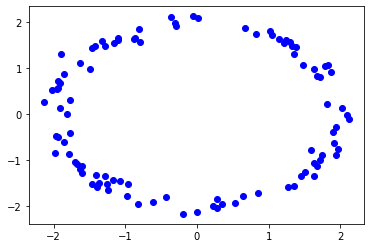

In [71]:
trial1 = sample_noisy_circle(2,100, 0.1)
plt.plot(trial1[:,0], trial1[:,1], 'bo')

In [5]:
# add a more extreme outlier/s to the circle
def sample_circle_outliers(r,n,centre=[0,0],noise=False, outlier = "centre"):
    # if noise is equal to some value (not False) then noise is the s.d. 
    # outlier types: "centre" (at 0,0), "single_extreme" (extremely outside the circle), 
    # "two" (one outlier in the centre and one outside circle)
    # "both" (one outlier in the centre and a few outside circle), 
    # "many" (many outliers about centre and many extremes)
    
    if noise==False:
        pts = sample_circle(r,n,centre)
    else:
        pts = sample_noisy_circle(r, n, noise, centre)
        
    # add outlier of the given type to sampled pts
    if outlier == "centre":
        out_pts = np.vstack([pts[:(n-1),:],[0,0]])
    elif outlier == "single_extreme":
        # sample a point 1.25 to 3 times outside the circle
        theta = random.random()*2*math.pi
        rad = random.uniform(1.25,3)
        out_pts = np.vstack([pts[:(n-1),:],[rad*r*math.cos(theta),rad*r*math.sin(theta)]])
    elif outlier == "two":
        theta = random.random()*2*math.pi
        rad = random.uniform(1.25,3)
        out_pts = np.vstack([pts[:(n-2),:],[0,0],[rad*r*math.cos(theta),rad*r*math.sin(theta)]])
    elif outlier == "both":
        out_pts = np.vstack([pts[:(n-6),:],[0,0]])
        for i in range(5):
            theta = random.random()*2*math.pi
            rad = random.uniform(1.25,3)
            out_pts = np.vstack([out_pts,[rad*r*math.cos(theta),rad*r*math.sin(theta)]])
    else:
        out_pts = np.vstack([pts[:(n-20),:],[0,0]])
        for i in range(10):
            theta = random.random()*2*math.pi
            rad = random.uniform(1.25,3)
            rad_x = random.random()*0.1
            rad_y = random.random()*0.1
            out_pts = np.vstack([out_pts,[rad_x,rad_y],[rad*r*math.cos(theta),rad*r*math.sin(theta)]])
    
    return out_pts


Text(0.5, 1.0, 'no noise with outlier in the centre')

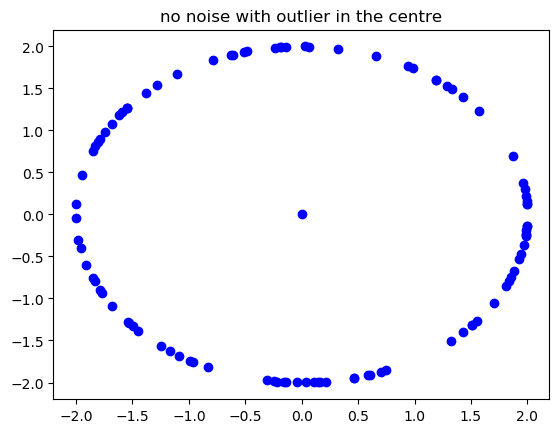

In [27]:
trial2 = sample_circle_outliers(2,100,centre=[0,0],noise=False, outlier = "centre")
plt.plot(trial2[:,0], trial2[:,1], 'bo')
plt.title("no noise with outlier in the centre")

Text(0.5, 1.0, '0.1 noise with outlier in the centre')

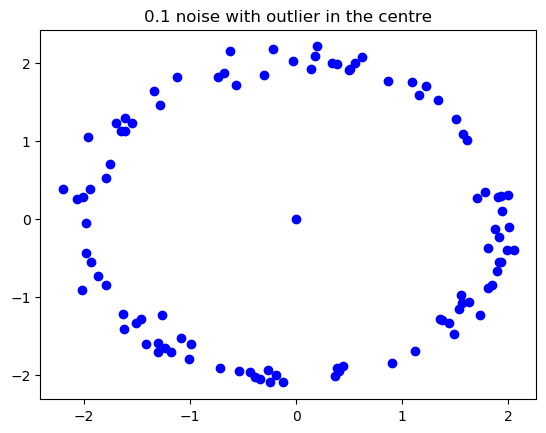

In [28]:
trial3 = sample_circle_outliers(2,100,centre=[0,0],noise=0.1, outlier = "centre")
plt.plot(trial3[:,0], trial3[:,1], 'bo')
plt.title("0.1 noise with outlier in the centre")

Text(0.5, 1.0, '0.1 noise with outlier outside the circle')

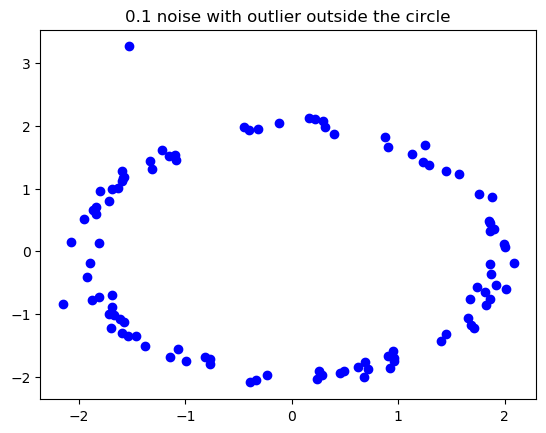

In [29]:
trial4 = sample_circle_outliers(2,100,centre=[0,0],noise=0.1, outlier = "single_extreme")
plt.plot(trial4[:,0], trial4[:,1], 'bo')
plt.title("0.1 noise with outlier outside the circle")

Text(0.5, 1.0, '0.1 noise with outlier both inside and outside the circle')

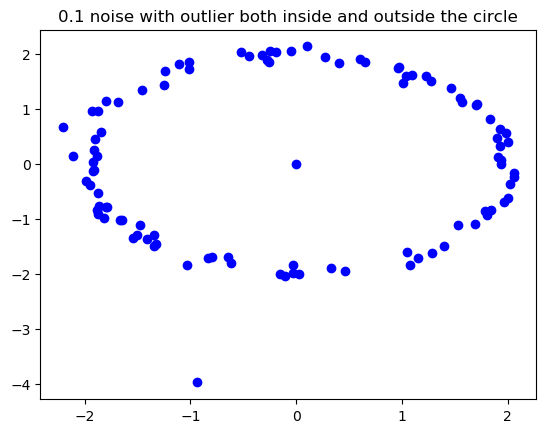

In [30]:
trial4 = sample_circle_outliers(2,100,centre=[0,0],noise=0.1, outlier = "two")
plt.plot(trial4[:,0], trial4[:,1], 'bo')
plt.title("0.1 noise with outlier both inside and outside the circle")

Text(0.5, 1.0, '0.1 noise with outliers outside the circle and at centre')

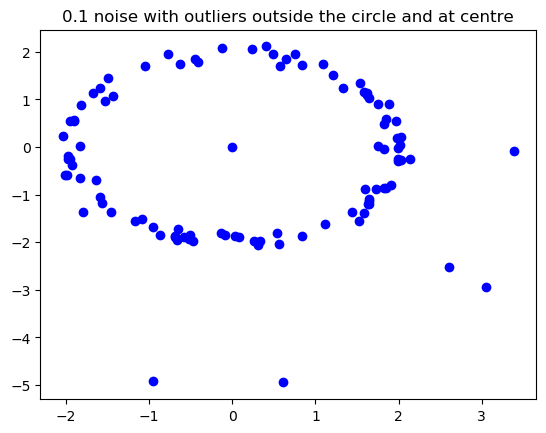

In [31]:
trial4 = sample_circle_outliers(2,100,centre=[0,0],noise=0.1, outlier = "both")
plt.plot(trial4[:,0], trial4[:,1], 'bo')
plt.title("0.1 noise with outliers outside the circle and at centre")

Text(0.5, 1.0, '0.1 noise with many outliers outside and inside the circle')

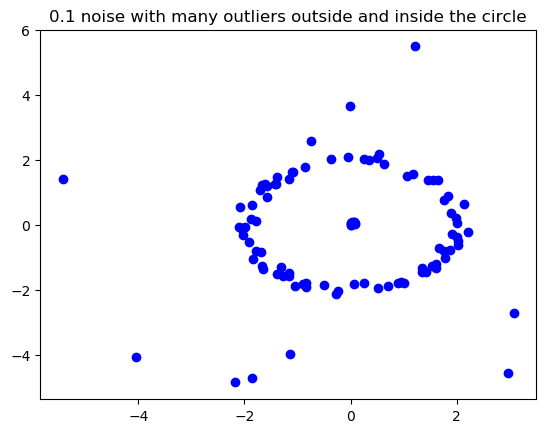

In [25]:
trial4 = sample_circle_outliers(2,100,centre=[0,0],noise=0.1, outlier = "many")
plt.plot(trial4[:,0], trial4[:,1], 'bo')
plt.title("0.1 noise with many outliers outside and inside the circle")

### Focus on the cases:
1. only one outlier in the centre
2. many outliers both inside and out


IDEA: generate 100 circles with point at centre and compute PH/PD & 100 noisy circles with point at centre and compute PH/PD & 100 normal circles and compute PH/PD

In [26]:
diagrams = ripser.ripser(trial4, maxdim=2)['dgms']

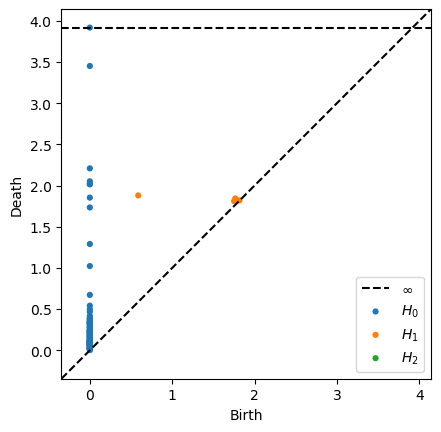

In [27]:

plot_diagrams(diagrams, show=True)

In [23]:
print(len(diagrams))
[a.shape for a in diagrams]

3


[(121, 2), (12, 2), (0, 2)]

### Generate 100 of each of these (with 100 pts each)
Case 0: normal circle 

Case 1: only one outlier in the centre

Case 2: many outliers both inside and out

In [6]:
# list of 100 samples from cicles
circle_samples = [0 for i in range(100)]
for i in range(100):
    circle_samples[i] = sample_circle(2,100)

In [7]:
# list of 100 samples of noisy circles
noisy_circle_samples = [0 for i in range(100)]
for i in range(100):
    noisy_circle_samples[i] = sample_noisy_circle(2,100, 0.1)

In [8]:
# list of 100 samples from cicles with pt in the center
centre_samples = [0 for i in range(100)]
for i in range(100):
    centre_samples[i] = sample_circle_outliers(2,100,centre=[0,0],noise=False, outlier = "centre")

In [9]:
# list of 100 samples from cicles with pt in the center
noisy_centre_samples = [0 for i in range(100)]
for i in range(100):
    noisy_centre_samples[i] = sample_circle_outliers(2,100,centre=[0,0],noise=0.1, outlier = "centre")

In [10]:
# list of 100 samples from cicles with pt in the center
extremes_samples = [0 for i in range(100)]
for i in range(100):
    extremes_samples[i] = sample_circle_outliers(2,100,centre=[0,0],noise=False, outlier = "many")

In [11]:
# list of 100 samples from cicles with pt in the center
noisy_extremes_samples = [0 for i in range(100)]
for i in range(100):
    noisy_extremes_samples[i] = sample_circle_outliers(2,100,centre=[0,0],noise=0.1, outlier = "many")

## Save all the samples as np arrays (100 by 200) so can be transported


In [15]:
circle_samples_array = np.concatenate(circle_samples, 1)
noisy_circle_samples_array = np.concatenate(noisy_circle_samples, 1)
centre_samples_array = np.concatenate(centre_samples, 1)
noisy_centre_samples_array = np.concatenate(noisy_centre_samples, 1)
extremes_samples_array = np.concatenate(extremes_samples, 1)
noisy_extremes_samples_array = np.concatenate(noisy_extremes_samples, 1)

In [20]:
np.savetxt('circle_samples_array.csv', circle_samples_array, delimiter=',') 
np.savetxt('noisy_circle_samples_array.csv', noisy_circle_samples_array, delimiter=',') 
np.savetxt('centre_samples_array.csv', centre_samples_array, delimiter=',') 
np.savetxt('noisy_centre_samples_array.csv', noisy_centre_samples_array, delimiter=',') 
np.savetxt('extremes_samples_array.csv', extremes_samples_array, delimiter=',') 
np.savetxt('noisy_extremes_samples_array.csv', noisy_extremes_samples_array, delimiter=',') 

In [19]:
circle_samples_array.shape

(100, 200)

In [40]:
# circle_samples_array = np.genfromtxt('circle_samples_array.csv', delimiter=',')
# noisy_circle_samples_array = np.genfromtxt('noisy_circle_samples_array.csv', delimiter=',')
# centre_samples_array = np.genfromtxt('centre_samples_array.csv', delimiter=',')
# noisy_centre_samples_array = np.genfromtxt('noisy_centre_samples_array.csv', delimiter=',')
# extremes_samples_array = np.genfromtxt('extremes_samples_array.csv', delimiter=',')
# noisy_extremes_samples_array = np.genfromtxt('noisy_extremes_samples_array.csv', delimiter=',')


In [45]:
circle_samples = [0 for i in range(100)]
centre_samples = [0 for i in range(100)]
extremes_samples = [0 for i in range(100)]
noisy_circle_samples = [0 for i in range(100)]
noisy_centre_samples = [0 for i in range(100)]
noisy_extremes_samples = [0 for i in range(100)]

for i in range(100):
    circle_samples[i] = circle_samples_array[:, (2*i):(2*i+2)]
    centre_samples[i] = centre_samples_array[:, (2*i):(2*i+2)]
    extremes_samples[i] = extremes_samples_array[:, (2*i):(2*i+2)]
    noisy_circle_samples[i] = noisy_circle_samples_array[:, (2*i):(2*i+2)]
    noisy_centre_samples[i] = noisy_centre_samples_array[:, (2*i):(2*i+2)]
    noisy_extremes_samples[i] = noisy_extremes_samples_array[:, (2*i):(2*i+2)]

In [46]:
circle_samples[0]

array([[ 1.94616458,  0.46091585],
       [-1.73464432,  0.99549438],
       [ 1.8479741 , -0.76484752],
       [ 1.04424419,  1.7057415 ],
       [ 1.27182735, -1.54352039],
       [-1.53114644, -1.28669755],
       [-1.28962165, -1.5286844 ],
       [-1.47152599, -1.35447822],
       [ 0.92896502, -1.77116459],
       [-1.37427079,  1.45305877],
       [ 0.36291075,  1.96679836],
       [-1.96376185,  0.3789979 ],
       [-0.42217577, -1.95493417],
       [-1.79419223, -0.88367089],
       [-0.34980251, -1.96917196],
       [ 1.99992982,  0.01675439],
       [ 1.96692553,  0.3622209 ],
       [-1.95140982,  0.43817772],
       [ 1.55690426,  1.25540795],
       [-1.89330049,  0.6445256 ],
       [-0.47323708,  1.94320526],
       [ 0.65469881, -1.88980673],
       [ 1.29152324, -1.52707816],
       [ 1.97752381, -0.29899762],
       [ 0.56095703,  1.91972061],
       [ 1.51190137,  1.30925713],
       [ 1.99561037, -0.13243588],
       [-1.65207779, -1.12722623],
       [ 1.96003743,

### Names of list of samples are: 

circle_samples / centre_samples / extremes_samples

noisy_circle_samples / noisy_centre_samples / noisy_extremes_samples

### Compute PD of the samples

In [47]:
# PD lists
circle_samples_PD = [0 for i in range(100)]
centre_samples_PD = [0 for i in range(100)]
extremes_samples_PD = [0 for i in range(100)]
noisy_circle_samples_PD = [0 for i in range(100)]
noisy_centre_samples_PD = [0 for i in range(100)]
noisy_extremes_samples_PD = [0 for i in range(100)]

for i in range(100):
    circle_samples_PD[i] = ripser.ripser(circle_samples[i], maxdim=2)['dgms']
    centre_samples_PD[i] = ripser.ripser(centre_samples[i], maxdim=2)['dgms']
    extremes_samples_PD[i] = ripser.ripser(extremes_samples[i], maxdim=2)['dgms']
    noisy_circle_samples_PD[i] = ripser.ripser(noisy_circle_samples[i], maxdim=2)['dgms']
    noisy_centre_samples_PD[i] = ripser.ripser(noisy_centre_samples[i], maxdim=2)['dgms']
    noisy_extremes_samples_PD[i] = ripser.ripser(noisy_extremes_samples[i], maxdim=2)['dgms']

In [54]:
ripser.ripser(circle_samples[0], maxdim=2)['dgms']

[array([[0.        , 0.00488565],
        [0.        , 0.00499699],
        [0.        , 0.00709449],
        [0.        , 0.00742234],
        [0.        , 0.00782936],
        [0.        , 0.00902213],
        [0.        , 0.01057236],
        [0.        , 0.0133636 ],
        [0.        , 0.01433601],
        [0.        , 0.01461827],
        [0.        , 0.01473931],
        [0.        , 0.01538452],
        [0.        , 0.02073037],
        [0.        , 0.02324555],
        [0.        , 0.02328167],
        [0.        , 0.02430774],
        [0.        , 0.02565687],
        [0.        , 0.02776799],
        [0.        , 0.03230742],
        [0.        , 0.03317012],
        [0.        , 0.03399339],
        [0.        , 0.03488635],
        [0.        , 0.03557007],
        [0.        , 0.03743106],
        [0.        , 0.04066598],
        [0.        , 0.04223532],
        [0.        , 0.04247079],
        [0.        , 0.04402341],
        [0.        , 0.04992273],
        [0.   

### Plot some diagrams

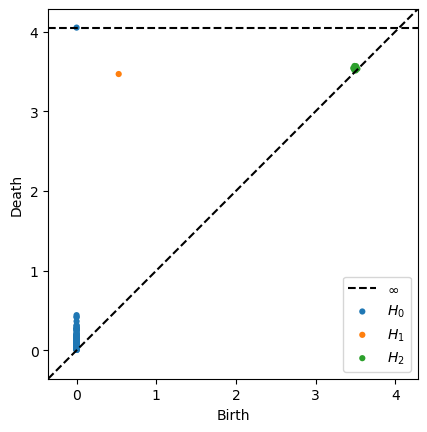

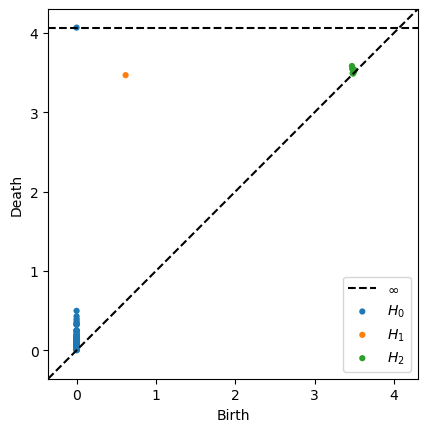

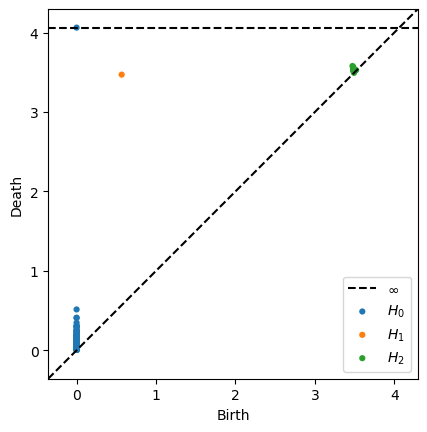

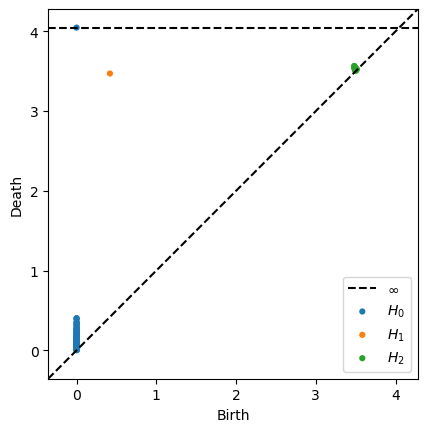

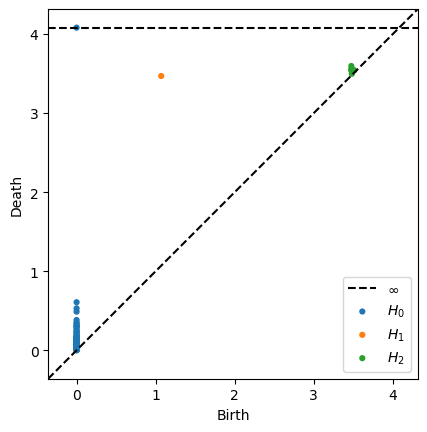

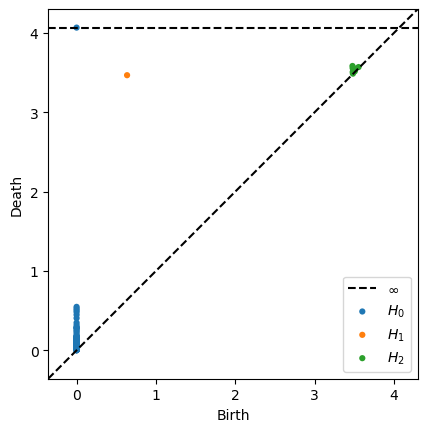

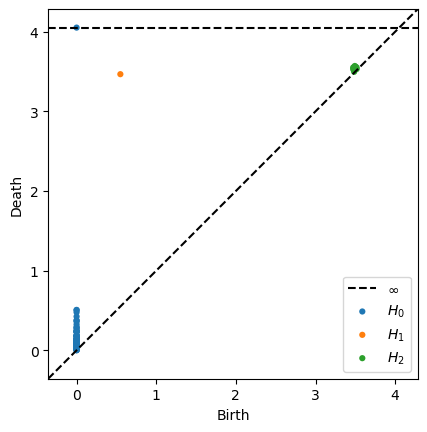

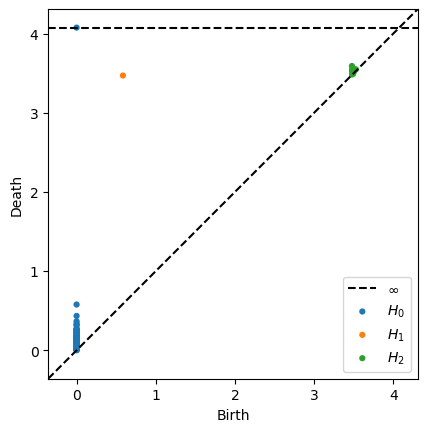

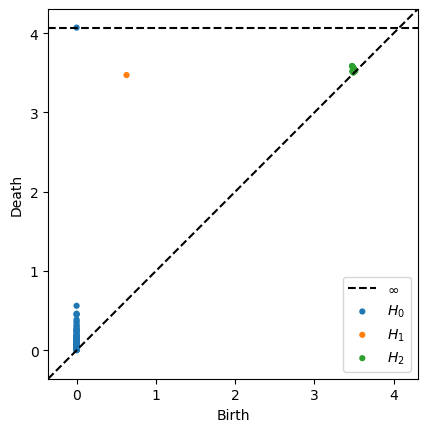

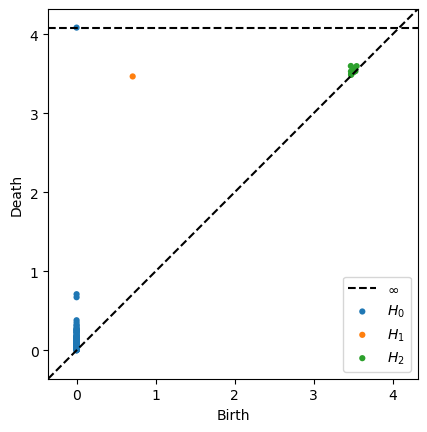

In [139]:
for i in range(10):
    plot_diagrams(circle_samples_PD[i], show=True)

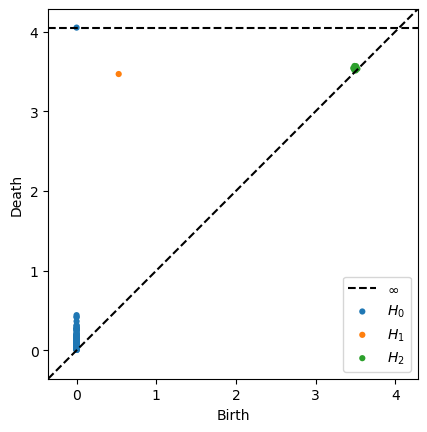

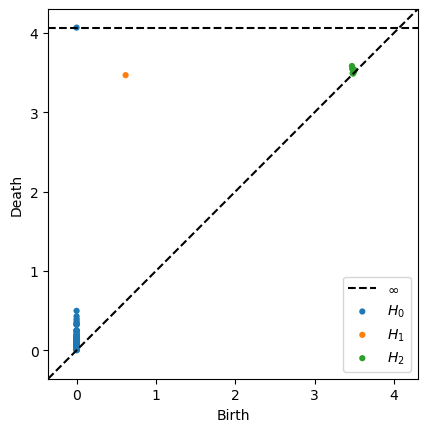

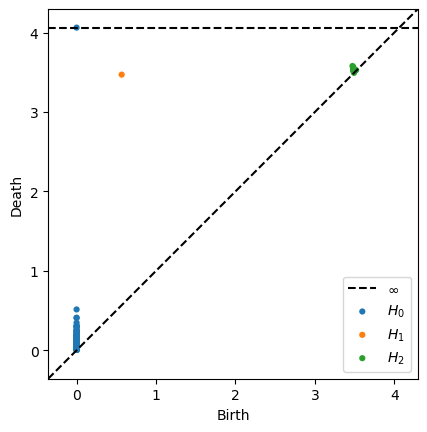

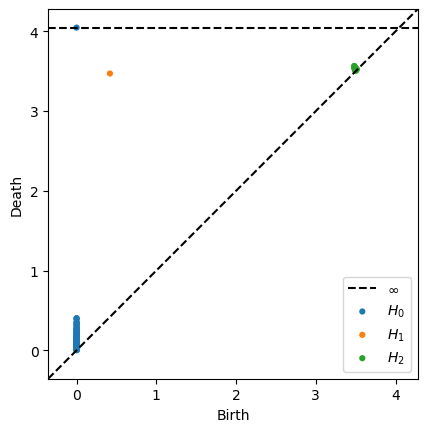

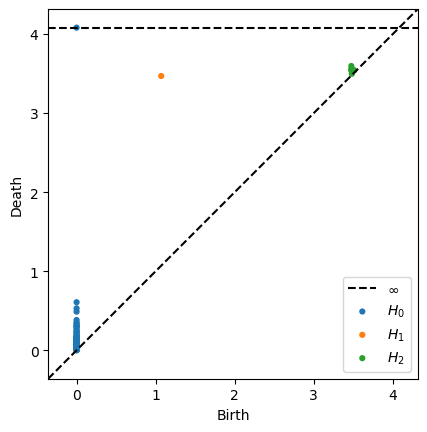

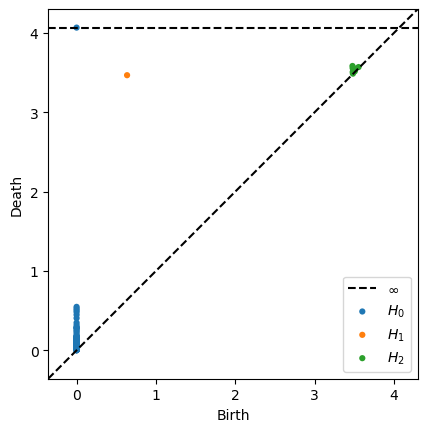

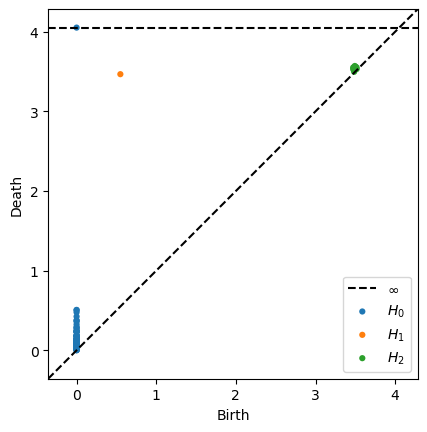

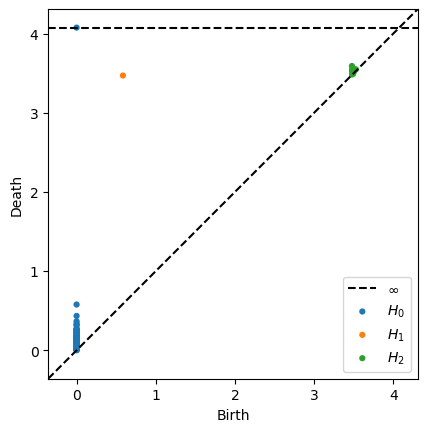

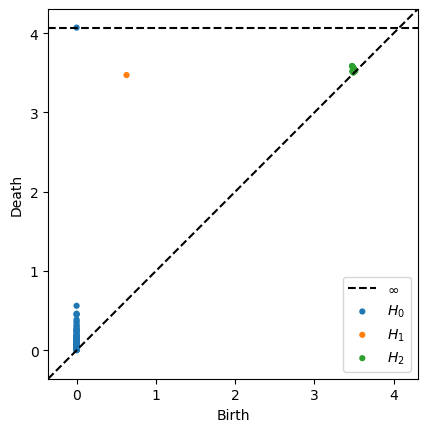

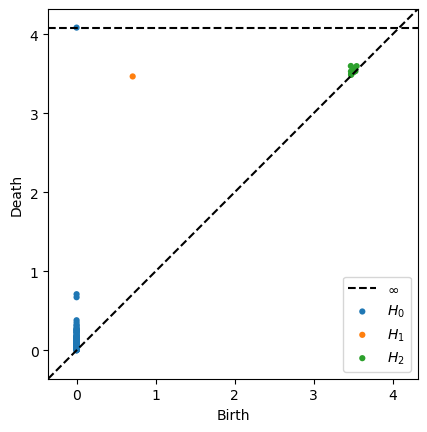

In [48]:
for i in range(10):
    plot_diagrams(circle_samples_PD[i], show=True)

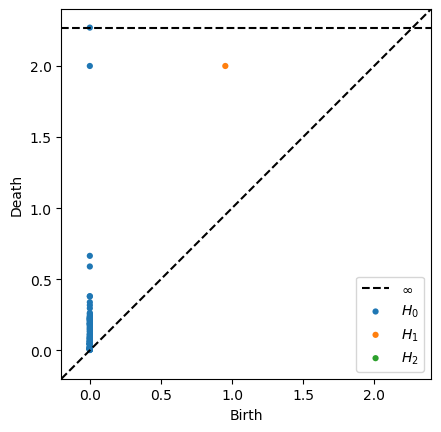

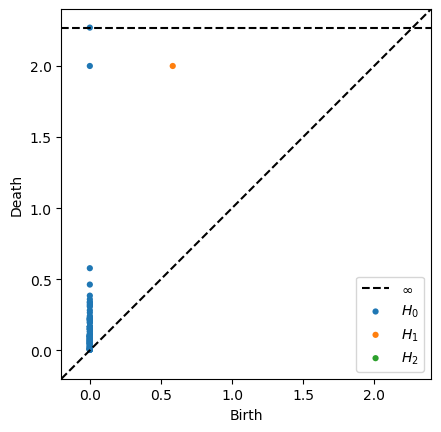

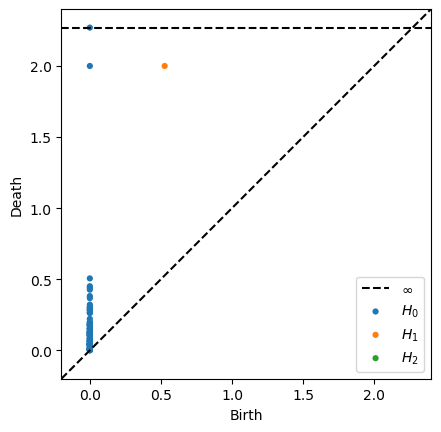

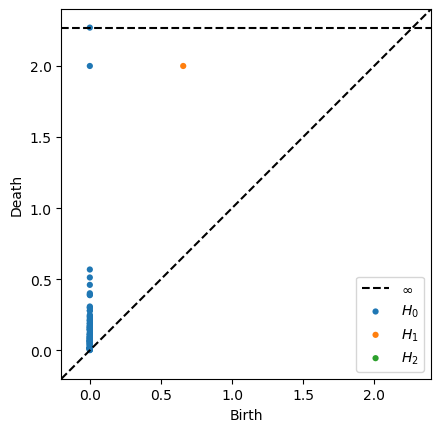

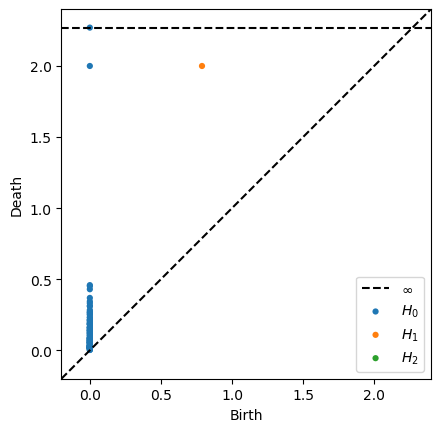

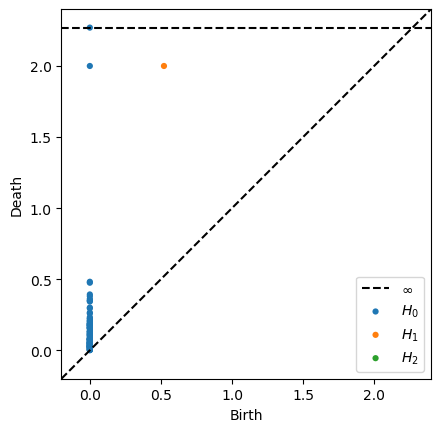

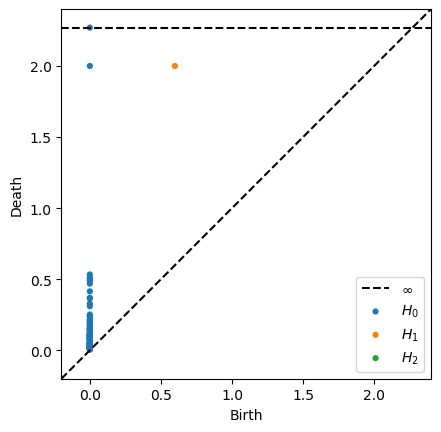

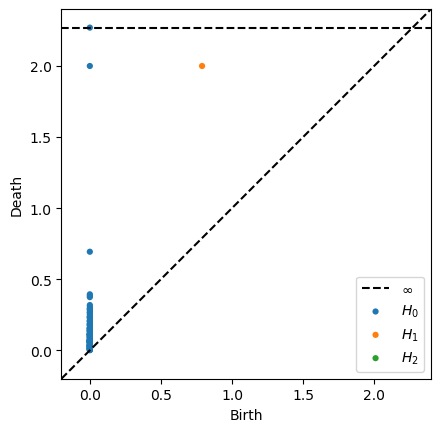

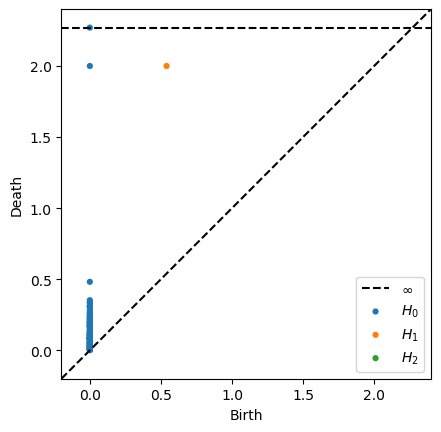

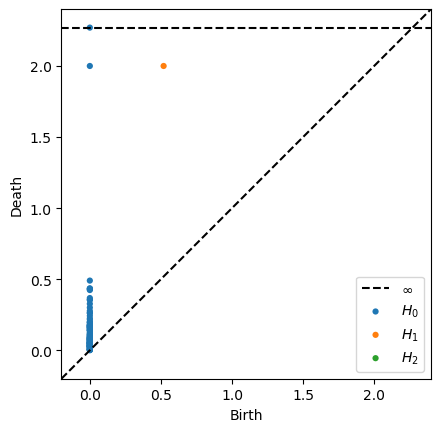

In [140]:
for i in range(10):
    plot_diagrams(centre_samples_PD[i], show=True)

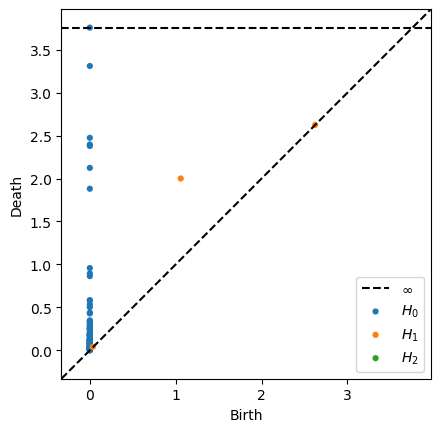

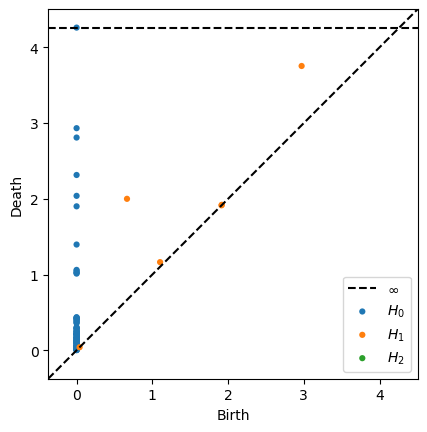

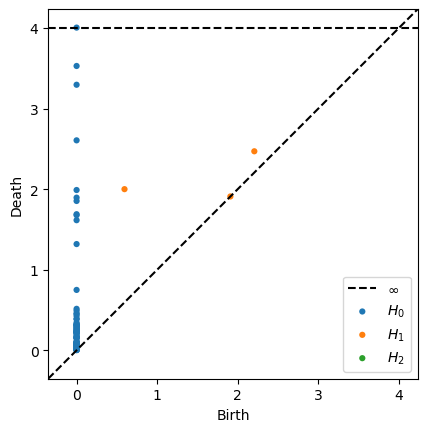

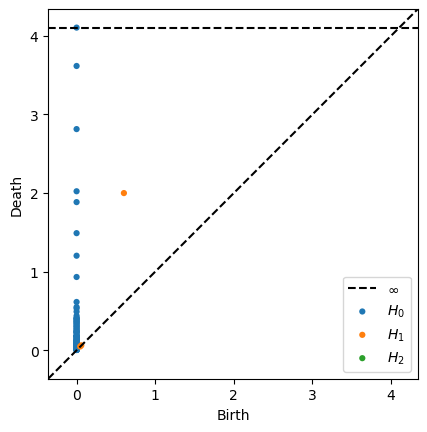

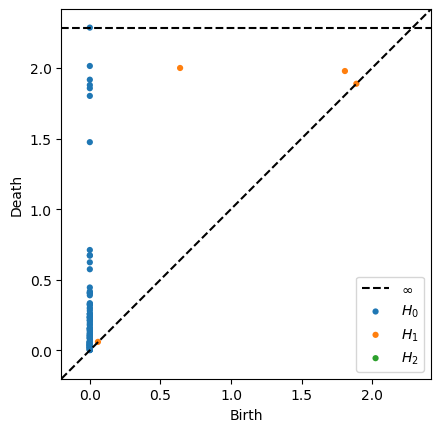

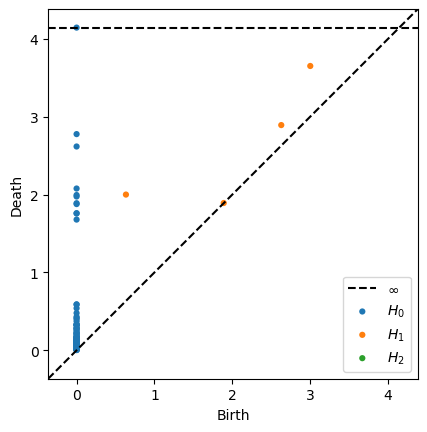

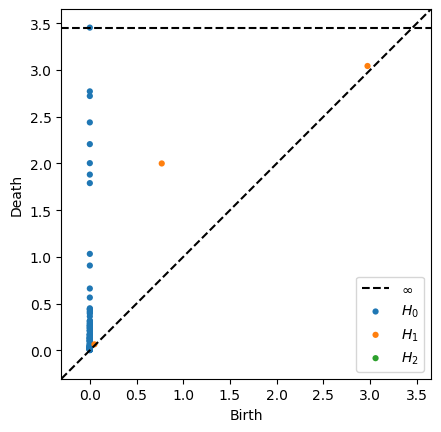

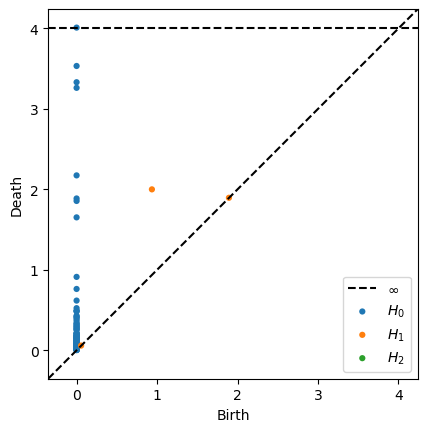

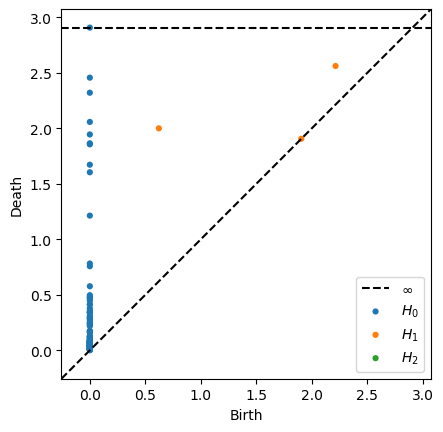

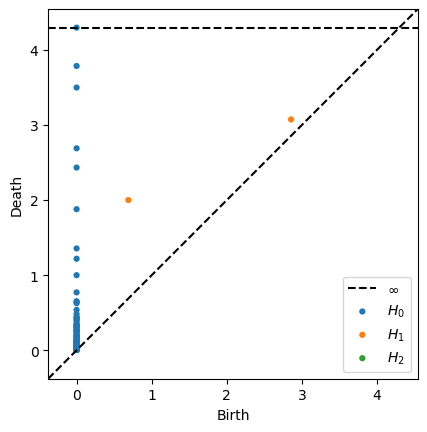

In [141]:
for i in range(10):
    plot_diagrams(extremes_samples_PD[i], show=True)

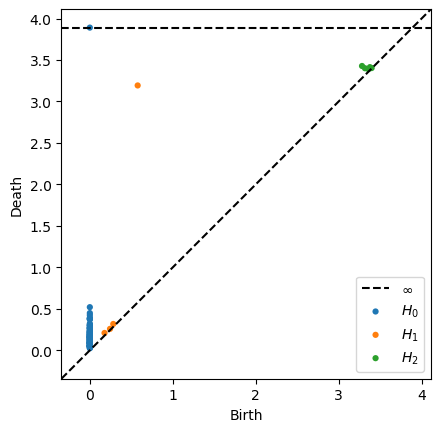

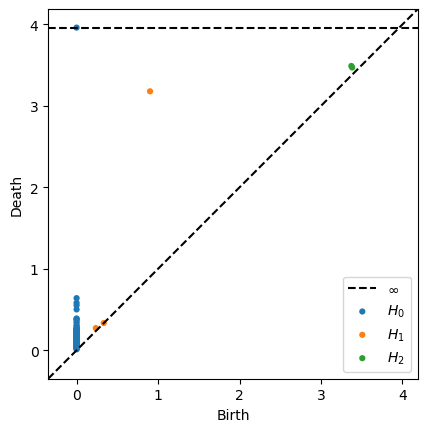

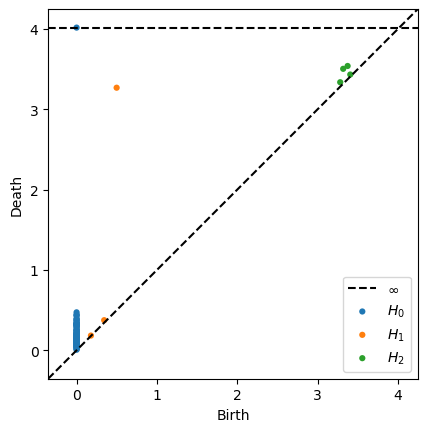

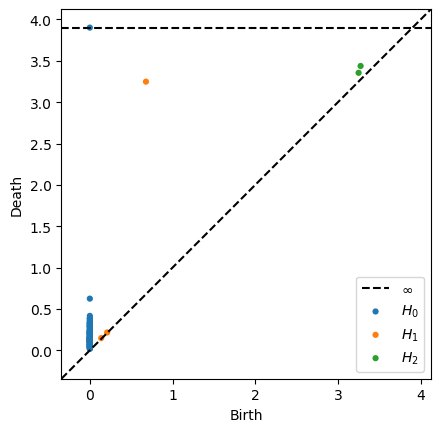

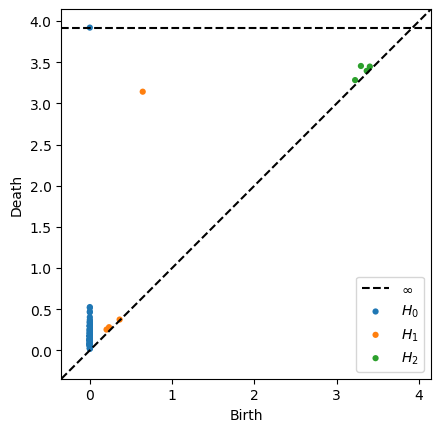

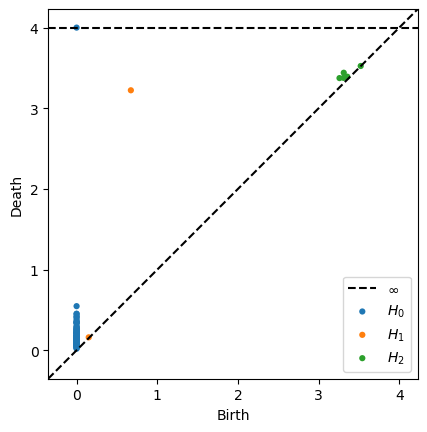

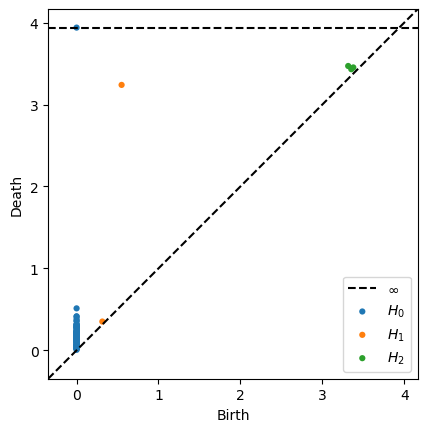

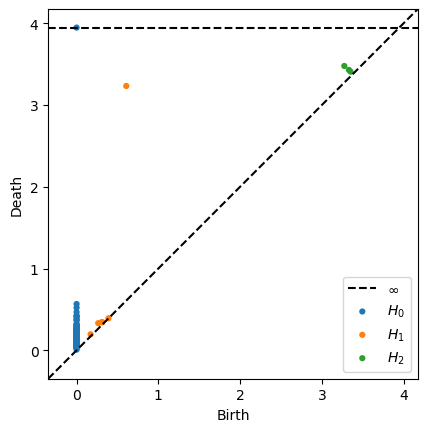

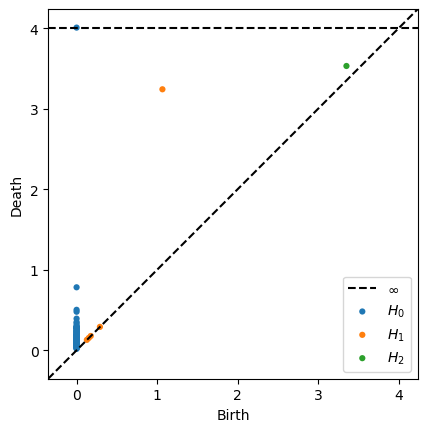

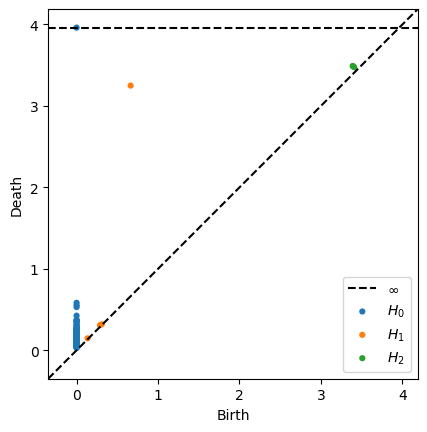

In [143]:
for i in range(10):
    plot_diagrams(noisy_circle_samples_PD[i], show=True)

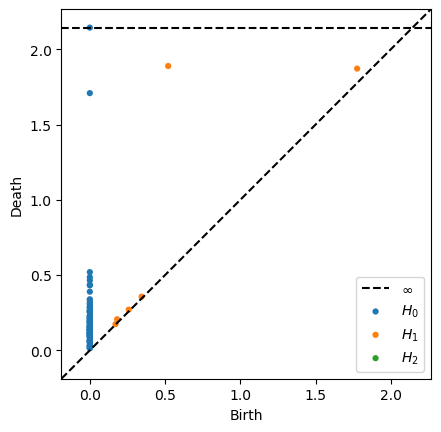

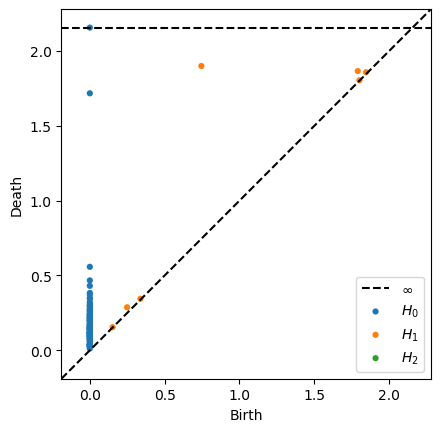

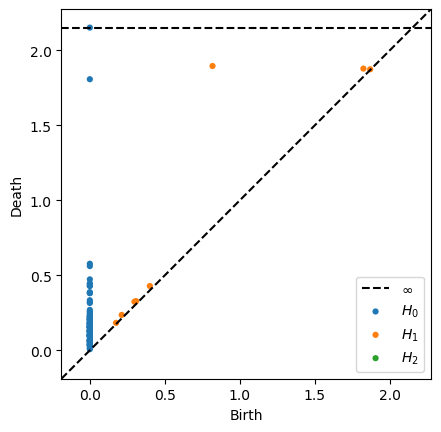

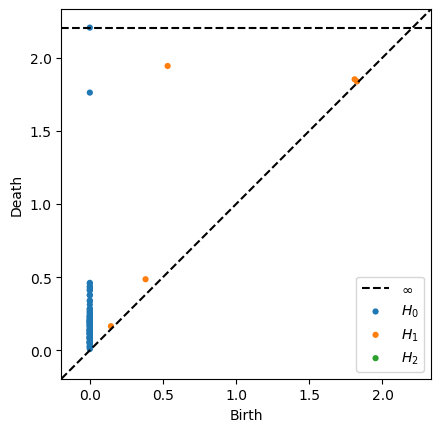

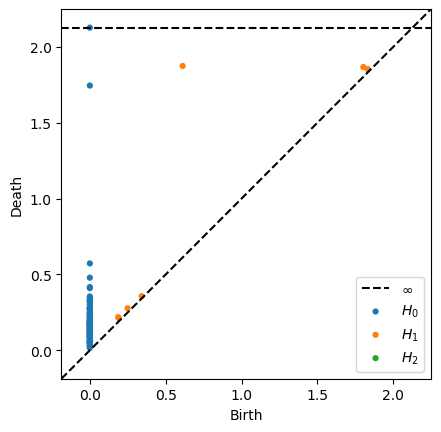

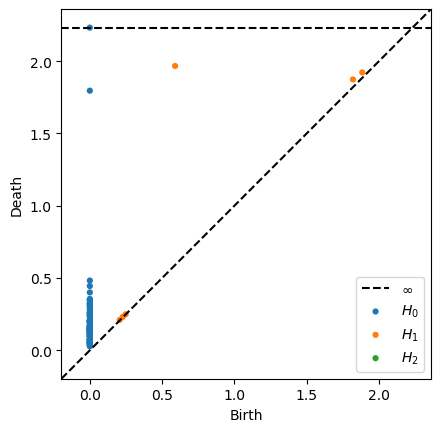

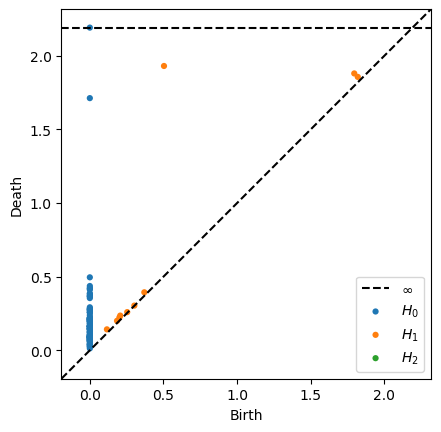

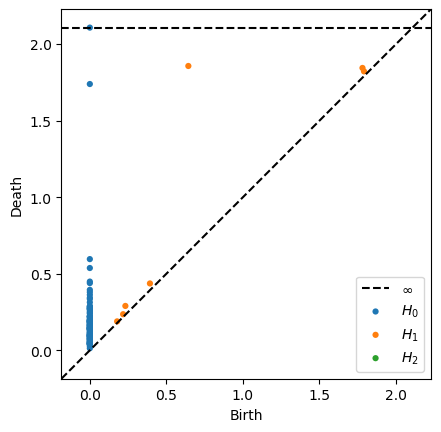

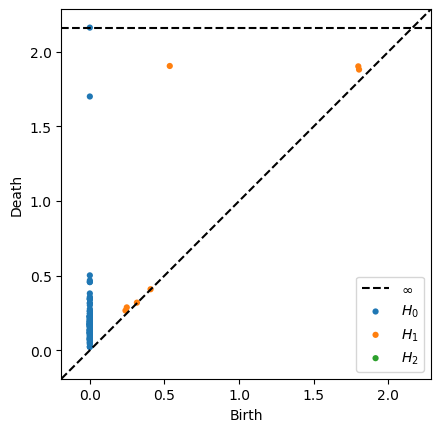

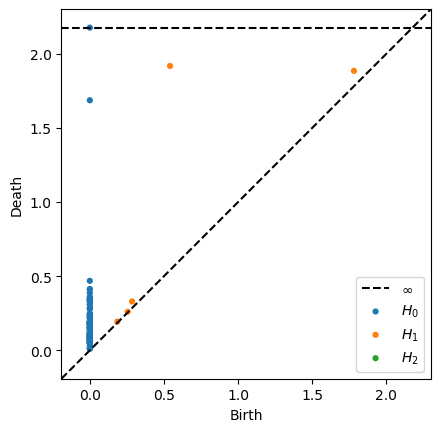

In [144]:
for i in range(10):
    plot_diagrams(noisy_centre_samples_PD[i], show=True)

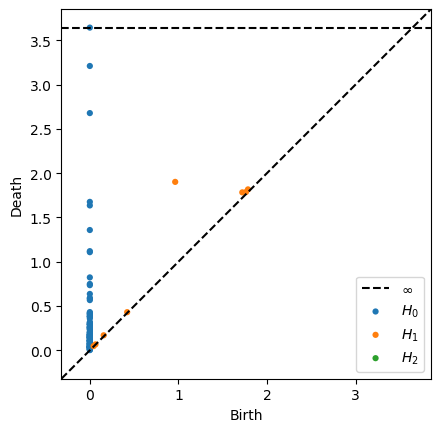

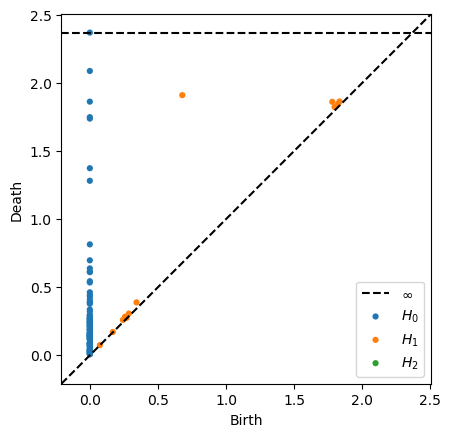

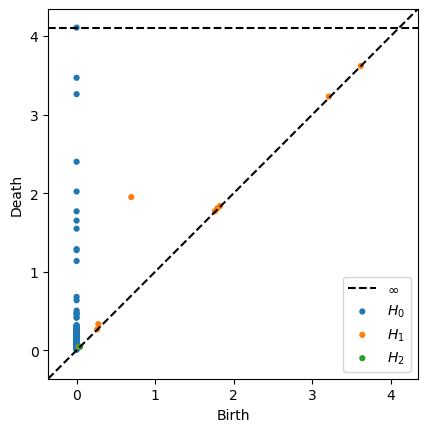

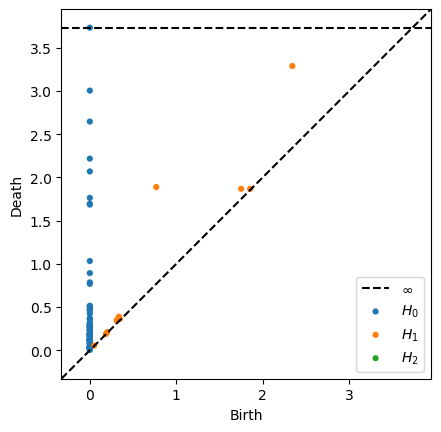

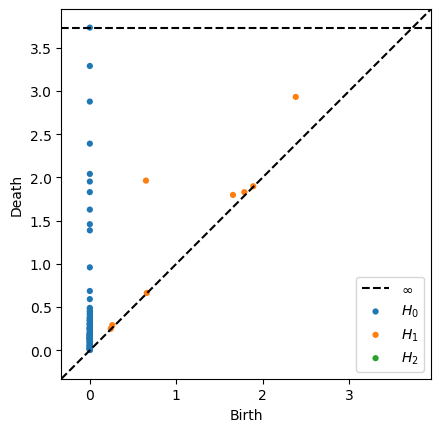

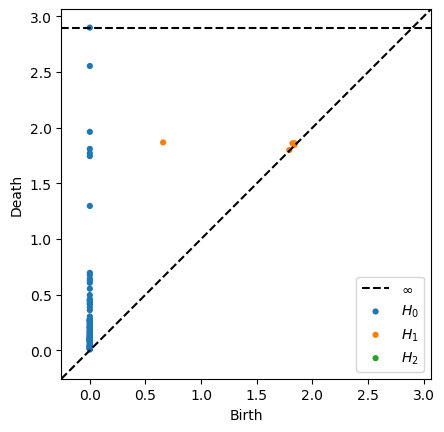

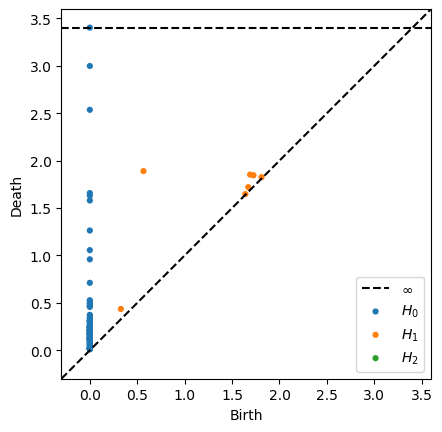

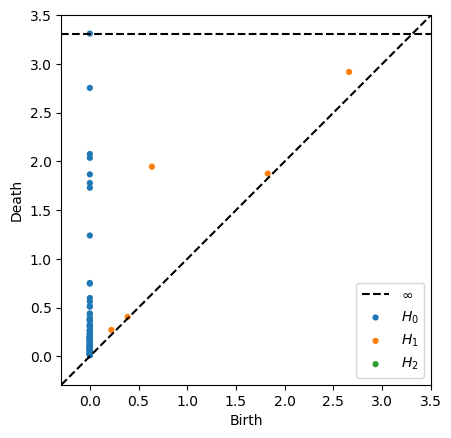

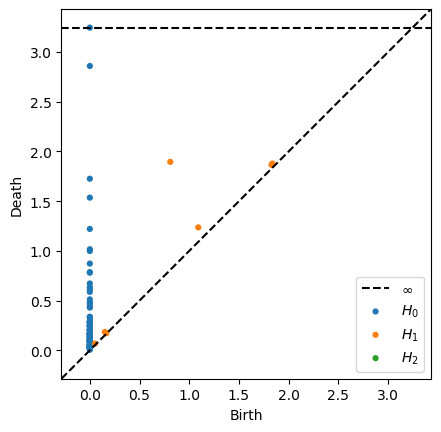

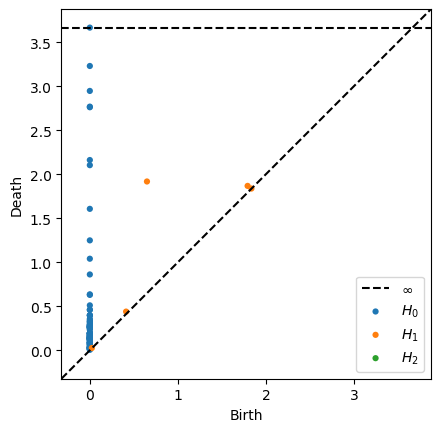

In [145]:
for i in range(10):
    plot_diagrams(noisy_extremes_samples_PD[i], show=True)

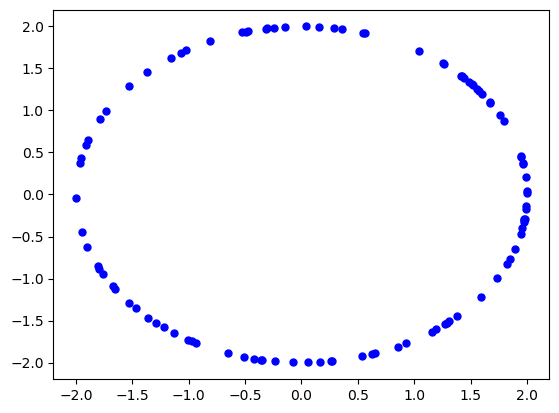

In [49]:
plt.plot(circle_samples[0][:,0],circle_samples[0][:,1], 'bo', markersize=5)

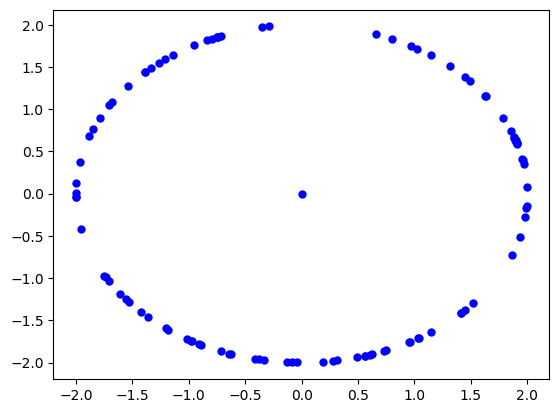

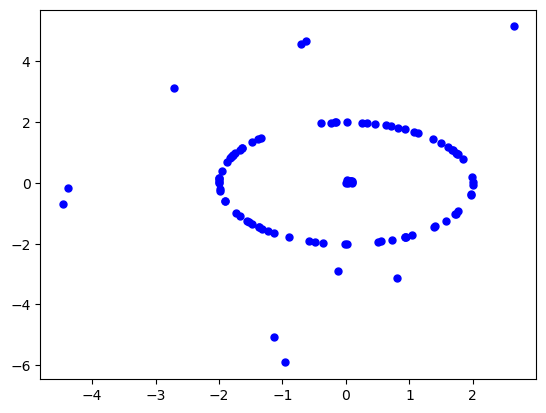

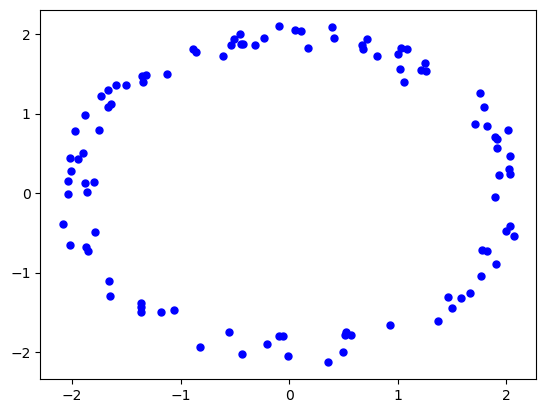

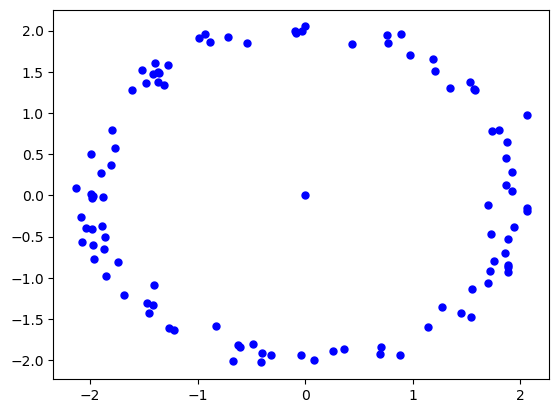

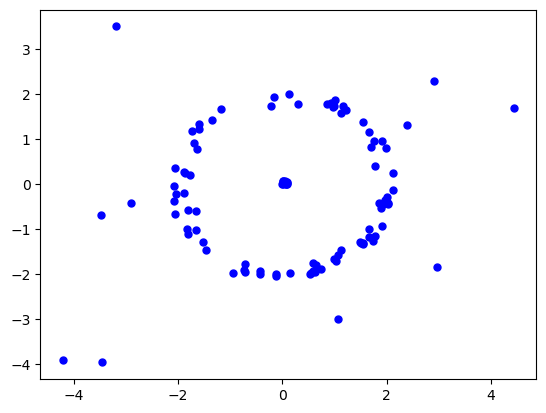

In [152]:
plt.plot(centre_samples[0][:,0],centre_samples[0][:,1], 'bo', markersize=5)
plt.show()
plt.plot(extremes_samples[0][:,0],extremes_samples[0][:,1], 'bo', markersize=5)
plt.show()
plt.plot(noisy_circle_samples[0][:,0],noisy_circle_samples[0][:,1], 'bo', markersize=5)
plt.show()
plt.plot(noisy_centre_samples[0][:,0],noisy_centre_samples[0][:,1], 'bo', markersize=5)
plt.show()
plt.plot(noisy_extremes_samples[0][:,0],noisy_extremes_samples[0][:,1], 'bo', markersize=5)
plt.show()

# Carry out the permutation test using the PDs


In [5]:
import persim

In [6]:
# define a function that given a distance matrix and indices of 2 groups compute the total variance
def dist_variance(dist_mat, index1, index2):
    var1 = 0
    for i in index1:
        for j in index1:
            var1 += dist_mat[i,j]
    var2 = 0
    for m in index2:
        for l in index2:
            var2 += dist_mat[m,l]
    n1 = len(index1)
    n2 = len(index2)
    tot_var = (var1/(2*n1*(n1-1))) + (var2/(2*n2*(n2-1)))
    return tot_var

In [75]:
def PD_permutation_test(sample1, sample2, N, dist_type="bottleneck", plot=False):
    # default distance type is bottleneck, but can have wasserstein dsitance as well
    n1 = len(sample1)
    n2 = len(sample2)
    labels = [i for i in range(n1+n2)]
    all_samples = sample1+sample2
    # compute a distance matrix between the two sets
    distances = np.zeros([n1+n2,n1+n2])
    for i in range(n1+n2):
        for j in range(i+1,n1+n2):
            if dist_type == "bottleneck":
                dist = persim.bottleneck(np.vstack(all_samples[i]), np.vstack(all_samples[j]))
                distances[i,j] = dist
                distances[j,i] = dist
            elif dist_type == "wasserstein":
                dist = persim.wasserstein(np.vstack(all_samples[i]), np.vstack(all_samples[j]))
                distances[i,j] = dist
                distances[j,i] = dist
        
                
    initial_variance = dist_variance(distances, [i for i in range(n1)], [i for i in range(n1,n1+n2)])
    
    variances = []
    z = 1
    # permute
    for k in range(N-1):
        random.shuffle(labels)
        ind1 = labels[:n1]
        ind2 = labels[n1:]
        
        new_variance = dist_variance(distances, ind1, ind2)
        
        variances.append(new_variance)
        
        if new_variance <= initial_variance:
            z += 1        
     
    # compute Z/N
    p_val = z/(N+1)
    
    if plot!=False:
        # plot the distribution of the variances under permutation
        result = plt.hist(variances, bins = 10,  color='c', edgecolor='k', alpha=0.65)
        plt.axvline(initial_variance, color='k', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        plt.text(initial_variance, max_ylim, 'Observed loss: {:.2f}'.format(initial_variance))
        plt.savefig(plot)
        plt.show()
    
    return p_val, variances

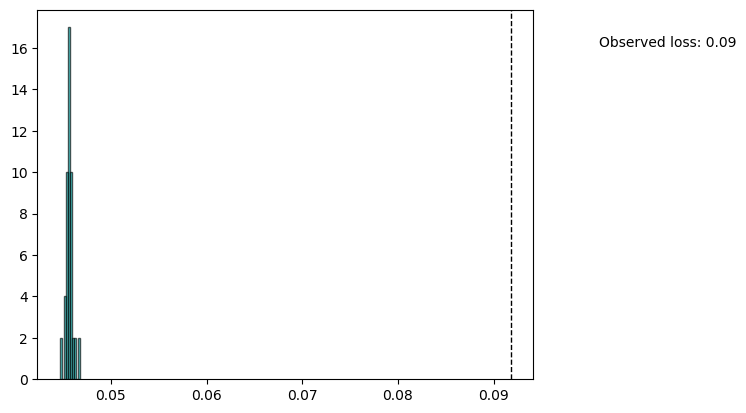

(0.9803921568627451,
 [0.045520069504326036,
  0.0458891032244822,
  0.04579724637245891,
  0.045610487899093916,
  0.04530323484329263,
  0.04573144179100942,
  0.04527582829799315,
  0.04522190658432065,
  0.045501864906212296,
  0.04592802523513033,
  0.04629466968955416,
  0.045676764824775735,
  0.045890088928769335,
  0.045453349895248504,
  0.04570646436377005,
  0.0453254077274992,
  0.04563888359250444,
  0.04571252476235833,
  0.04550901824928293,
  0.04567793312548386,
  0.045523720890885654,
  0.04558975064995313,
  0.04578452619037243,
  0.04557855397462845,
  0.04556721601221296,
  0.04571997307316221,
  0.04550378629956582,
  0.045801350850649555,
  0.045692833856199724,
  0.04674465805894197,
  0.045688716317668104,
  0.045613959922332956,
  0.045957987076706355,
  0.04565057274970141,
  0.045240849596683425,
  0.04573345339508972,
  0.0467664956941147,
  0.044672334755610936,
  0.04524556009606881,
  0.0456085181943696,
  0.045865073824169655,
  0.04594727256532871,
  

In [181]:
PD_permutation_test(circle_samples_PD, noisy_circle_samples_PD, 50, plot=True)

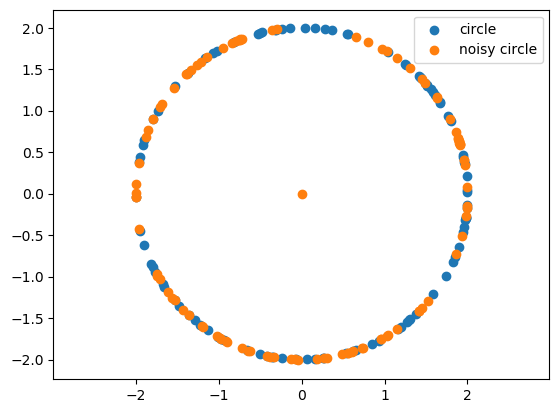

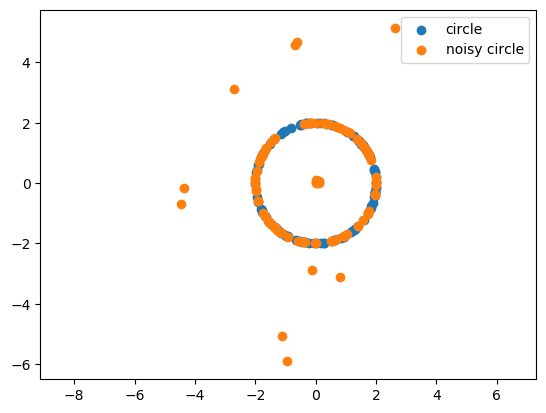

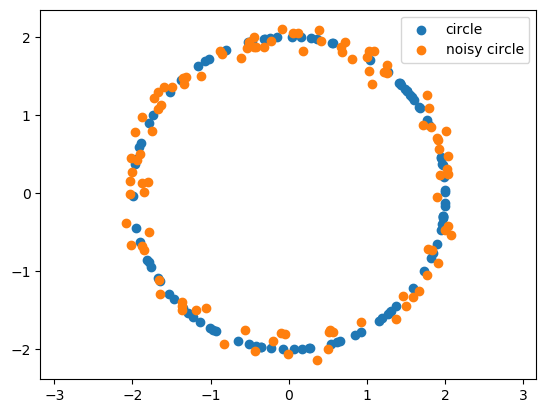

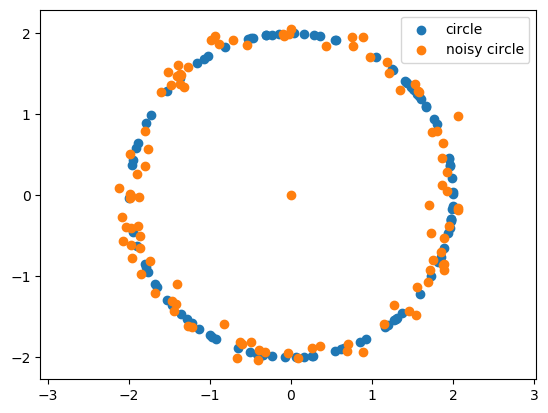

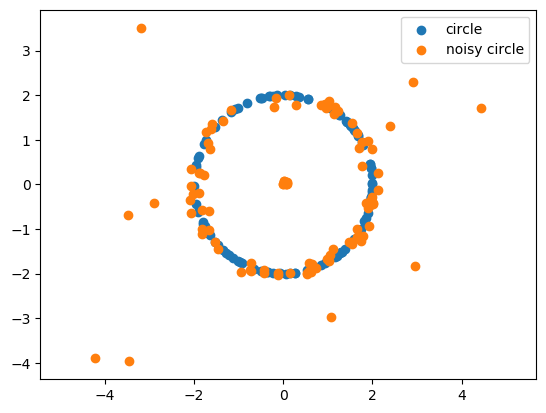

In [50]:
# plots of circle overlaid with the different types
plt.scatter(circle_samples[0][:,0], circle_samples[0][:,1], label="circle")
plt.scatter(centre_samples[0][:,0], centre_samples[0][:,1], label="noisy circle")
plt.axis('equal')
plt.legend()
plt.show()

plt.scatter(circle_samples[0][:,0], circle_samples[0][:,1], label="circle")
plt.scatter(extremes_samples[0][:,0], extremes_samples[0][:,1], label="noisy circle")
plt.axis('equal')
plt.legend()
plt.show()

plt.scatter(circle_samples[0][:,0], circle_samples[0][:,1], label="circle")
plt.scatter(noisy_circle_samples[0][:,0], noisy_circle_samples[0][:,1], label="noisy circle")
plt.axis('equal')
plt.legend()
plt.show()

plt.scatter(circle_samples[0][:,0], circle_samples[0][:,1], label="circle")
plt.scatter(noisy_centre_samples[0][:,0], noisy_centre_samples[0][:,1], label="noisy circle")
plt.axis('equal')
plt.legend()
plt.show()

plt.scatter(circle_samples[0][:,0], circle_samples[0][:,1], label="circle")
plt.scatter(noisy_extremes_samples[0][:,0], noisy_extremes_samples[0][:,1], label="noisy circle")
plt.axis('equal')
plt.legend()
plt.show()


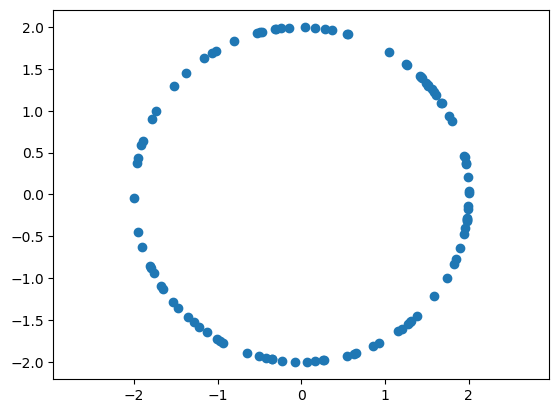

In [74]:
# plots of circle overlaid with the different types
plt.scatter(circle_samples[0][:,0], circle_samples[0][:,1])
plt.axis('equal')
plt.show()

In [76]:
import warnings
warnings.filterwarnings('ignore')

make the plots save with names


[0, 1]


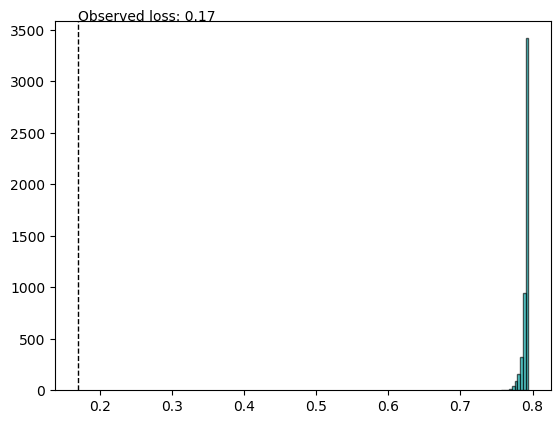

[0, 2]


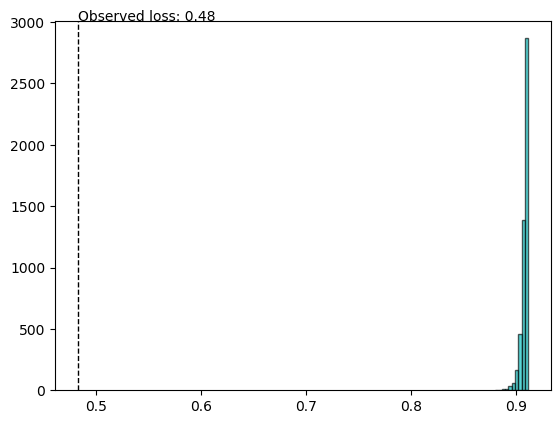

[0, 3]


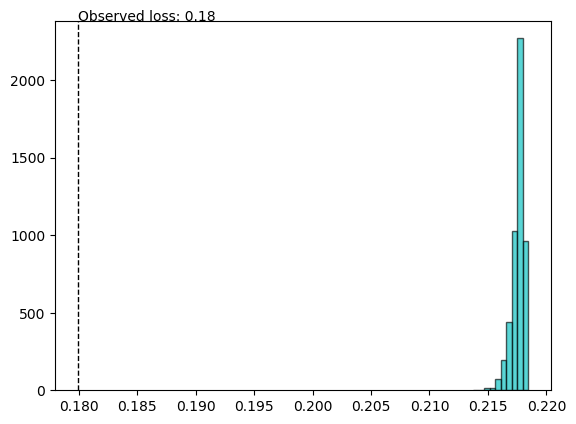

[0, 4]


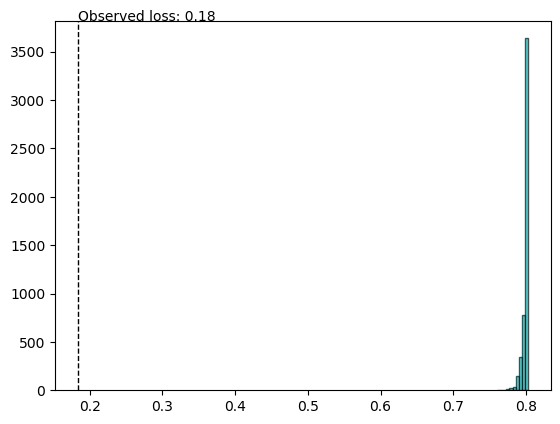

[0, 5]


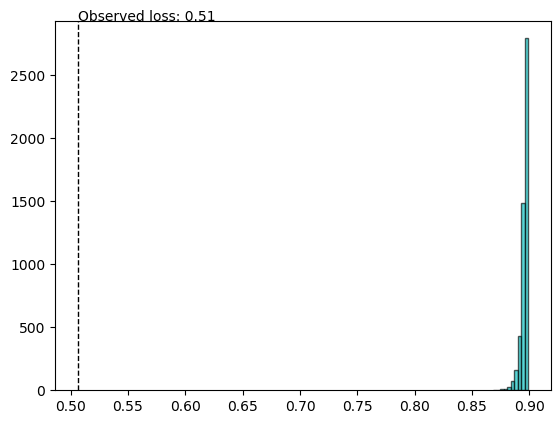

[1, 2]


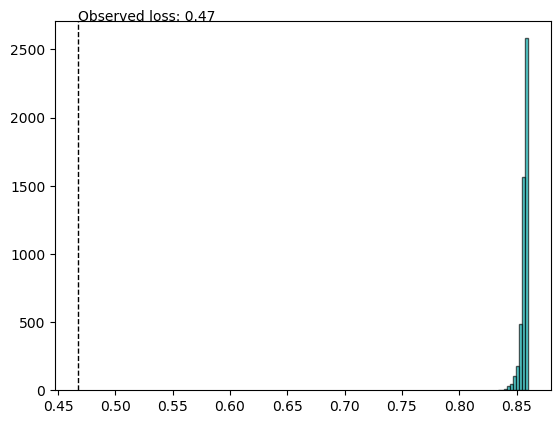

[1, 3]


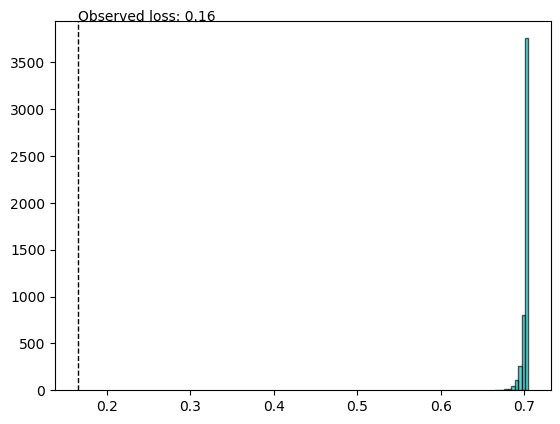

[1, 4]


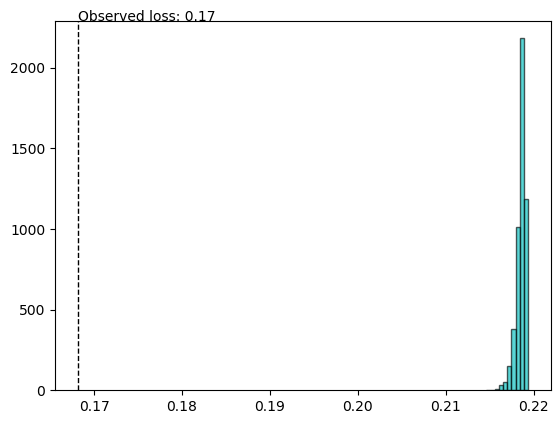

[1, 5]


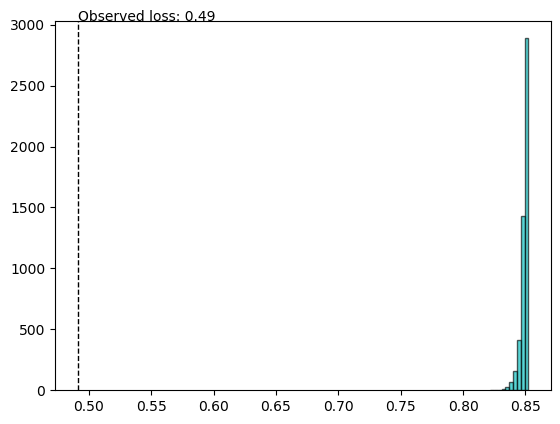

[2, 3]


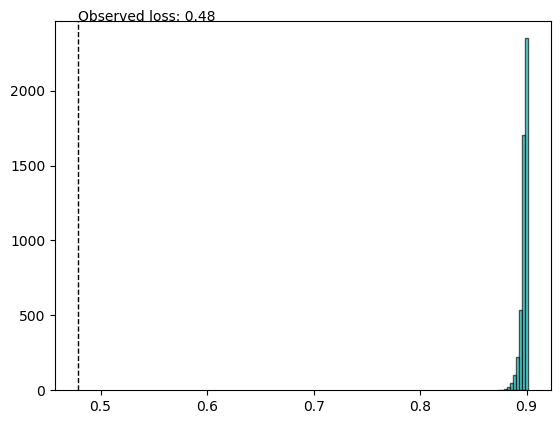

[2, 4]


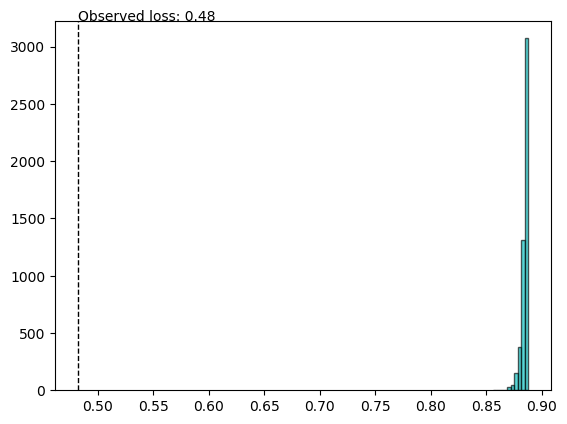

[2, 5]


KeyboardInterrupt: 

In [77]:
all_PD = [circle_samples_PD, centre_samples_PD, extremes_samples_PD, noisy_circle_samples_PD, 
noisy_centre_samples_PD, noisy_extremes_samples_PD]

names = ["circle","centre","extremes","noisycircle","noisycentre","noisyextremes"]

p_vals_bot_PD = np.zeros([6,6])
for i in range(6):
    for j in range(i+1,6):
        print([i,j])
        abc, de = PD_permutation_test(all_PD[i], all_PD[j], 5000, dist_type="bottleneck", plot=names[i]+"_"+names[j]+"_bottleneck.png")
        p_vals_bot_PD[i,j] = abc

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/bottleneck.py:57: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/bottleneck.py:67: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+


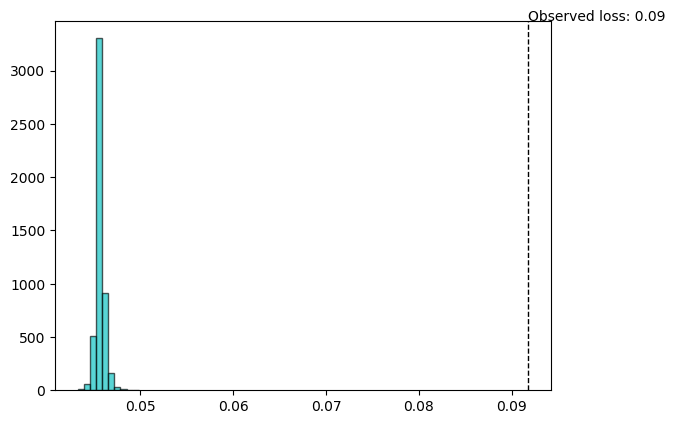

(0.9998000399920016,
 [0.04582104801379069,
  0.046115122887522286,
  0.04544824651395432,
  0.046343917289767604,
  0.045823751301175414,
  0.045567899448703035,
  0.04566942318521365,
  0.04554575298169647,
  0.043311372120874096,
  0.04460493892130225,
  0.045580751980193936,
  0.04561826366366763,
  0.04589549495565771,
  0.045690424302310656,
  0.04627191693042264,
  0.04510752642094487,
  0.045573130779796175,
  0.045745671511900544,
  0.045541836813543776,
  0.04572421743111177,
  0.044854327524551235,
  0.046541362802187604,
  0.045959616676725525,
  0.04521614480801303,
  0.045774564919146624,
  0.04534282030631798,
  0.045733321924703293,
  0.045690385706797995,
  0.04565638787668161,
  0.04559965605537097,
  0.0463506975333498,
  0.045690986708258136,
  0.045499883536437545,
  0.045408954983106764,
  0.04727146572536892,
  0.04517020620029382,
  0.0455022668462209,
  0.04578387626343303,
  0.04574592601018723,
  0.046046916129011094,
  0.04565256529384189,
  0.04616956871868

In [72]:
PD_permutation_test(circle_samples_PD, centre_samples_PD, 5000, dist_type="bottleneck", plot="testing.png")

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:62: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  "dgm2 has points with non-finite death times;"+
/home/qw817/anaconda3/lib/python3.7/site-packages/persim/wasserstein.py:52: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  "dgm1 has points with n

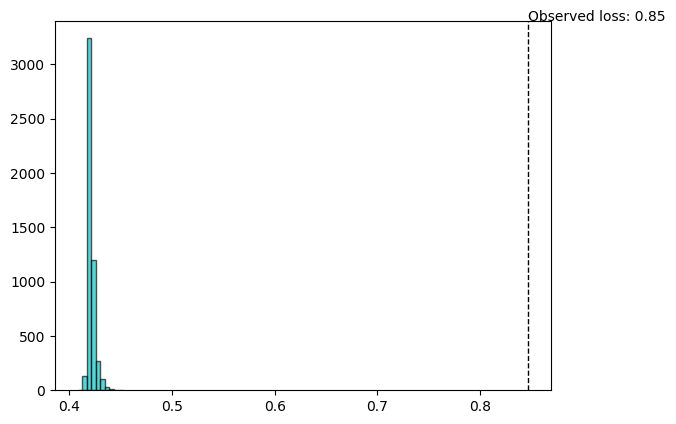

(0.9998000399920016,
 [0.42165617891470053,
  0.42233074007825233,
  0.42048988784324015,
  0.4227640209288014,
  0.41719966113115137,
  0.42108806964157364,
  0.42129506087579427,
  0.41531305935506957,
  0.4214485324443787,
  0.4333919339219431,
  0.41975543340161003,
  0.4214313590462344,
  0.41826924713021557,
  0.42164404342598605,
  0.42008168119357314,
  0.4222654464673869,
  0.4168905067376931,
  0.4279332906966411,
  0.4195819950871967,
  0.42913355610191284,
  0.4213119242081883,
  0.4229813284779045,
  0.4248383169134541,
  0.4208840260021137,
  0.41727155185056575,
  0.4195238997890772,
  0.42144217742841344,
  0.41799401430313765,
  0.42198838057696386,
  0.4203783047175286,
  0.42026568230102557,
  0.42083431148202727,
  0.4197011817747668,
  0.4216343640253975,
  0.41993876498781546,
  0.42034111687624653,
  0.4253428133317717,
  0.4197572485149804,
  0.42067011035795776,
  0.42154346865967274,
  0.4214126569016443,
  0.41440937347149986,
  0.41540525199950107,
  0.41930

In [73]:
PD_permutation_test(circle_samples_PD, centre_samples_PD, 5000, dist_type="wasserstein", plot="testing2.png")

In [12]:
p_vals_bot_PD

array([[0.        , 0.99980004, 0.99980004, 0.99980004, 0.99980004,
        0.99980004],
       [0.        , 0.        , 0.99980004, 0.99980004, 0.99980004,
        0.99980004],
       [0.        , 0.        , 0.        , 0.99980004, 0.99980004,
        0.99980004],
       [0.        , 0.        , 0.        , 0.        , 0.99980004,
        0.99980004],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.99980004],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [13]:
np.savetxt("p_vals_bottleneck.csv", p_vals_bot_PD, delimiter=",")

[0, 1]


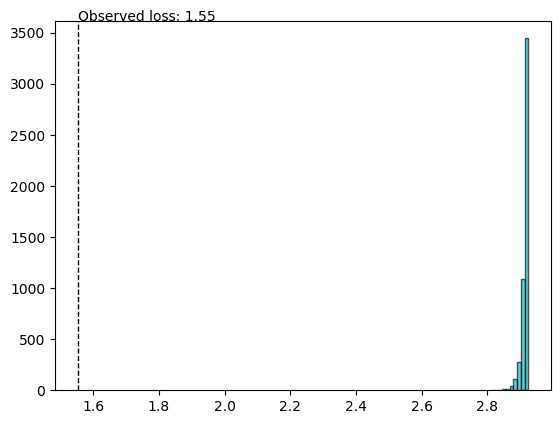

[0, 2]


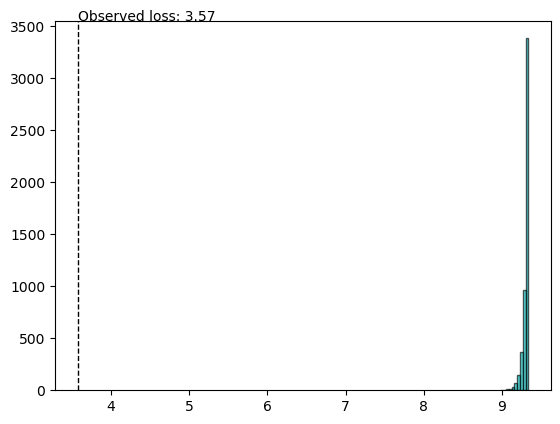

[0, 3]


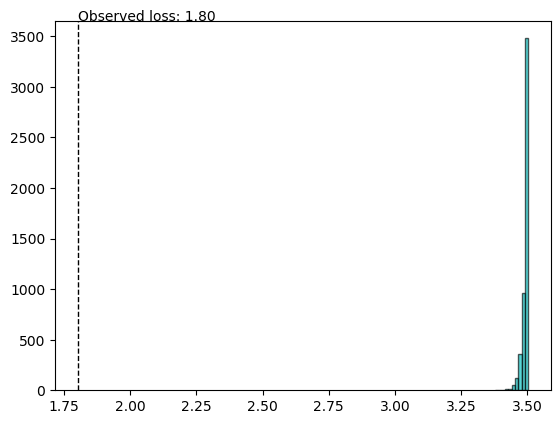

[0, 4]


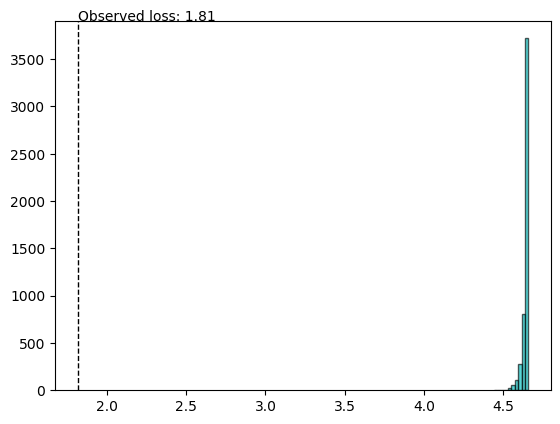

[0, 5]


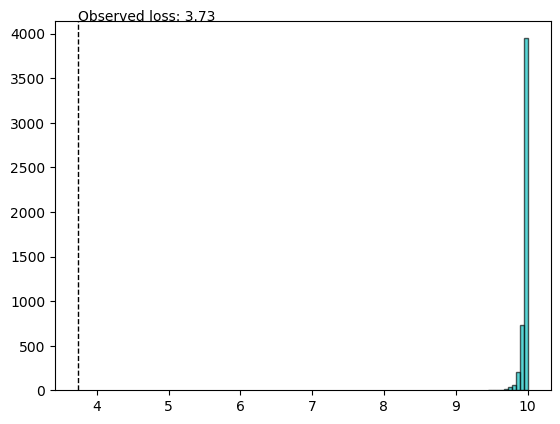

In [78]:
all_PD = [circle_samples_PD, centre_samples_PD, extremes_samples_PD, noisy_circle_samples_PD, 
noisy_centre_samples_PD, noisy_extremes_samples_PD]

names = ["circle","centre","extremes","noisycircle","noisycentre","noisyextremes"]

p_vals_was_PD = np.zeros([6,6])
for i in range(1):#range(6)
    for j in range(i+1,6):
        print([i,j])
        abc, de = PD_permutation_test(all_PD[i], all_PD[j], 5000, dist_type="wasserstein", plot=names[i]+"_"+names[j]+"_wasserstein.png")
        p_vals_was_PD[i,j] = abc

In [9]:
p_vals_was_PD

array([[0.        , 0.99980004, 0.99980004, 0.99980004, 0.99980004,
        0.99980004],
       [0.        , 0.        , 0.99980004, 0.99980004, 0.99980004,
        0.99980004],
       [0.        , 0.        , 0.        , 0.99980004, 0.99980004,
        0.99980004],
       [0.        , 0.        , 0.        , 0.        , 0.99980004,
        0.99980004],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.99980004],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [10]:
np.savetxt("p_vals_wasserstein.csv", p_vals_was_PD, delimiter=",")

In [15]:
from compute_rank_function_from_barcode import rank_function



In [66]:
# rank function lists for dim = 0
circle_samples_rank_fns = [0 for i in range(100)]
centre_samples_rank_fns = [0 for i in range(100)]
extremes_samples_rank_fns = [0 for i in range(100)]
noisy_circle_samples_rank_fns = [0 for i in range(100)]
noisy_centre_samples_rank_fns = [0 for i in range(100)]
noisy_extremes_samples_rank_fns = [0 for i in range(100)]

for i in range(100):
    circle_samples_rank_fns[i] = rank_function(circle_samples_PD[i], 0, 20, [0,4])
    centre_samples_rank_fns[i] = rank_function(centre_samples_PD[i], 0, 20, [0,4])
    extremes_samples_rank_fns[i] = rank_function(extremes_samples_PD[i], 0, 20, [0,4])
    noisy_circle_samples_rank_fns[i] = rank_function(noisy_circle_samples_PD[i], 0, 20, [0,4])
    noisy_centre_samples_rank_fns[i] = rank_function(noisy_centre_samples_PD[i], 0, 20, [0,4])
    noisy_extremes_samples_rank_fns[i] = rank_function(noisy_extremes_samples_PD[i], 0, 20, [0,4])


### Plot rank functions for visualization

In [64]:
x = np.linspace(-0.2, 4, 20)
y = np.linspace(4, -0.2, 20)

X, Y = np.meshgrid(x, y)

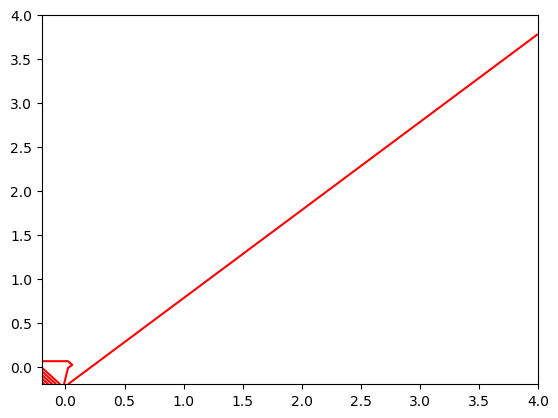

In [65]:
plt.contour(X, Y, rank_function(circle_samples_PD[0], 0, 20, [0,4])+rank_function(circle_samples_PD[0], 1, 20, [0,4])+rank_function(circle_samples_PD[0], 2, 20, [0,4]), colors='red')



In [58]:
X

array([[0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
        1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
        2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
        3.15789474, 3.36842105, 3.57894737, 3.78947368, 4.        ],
       [0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
        1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
        2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
        3.15789474, 3.36842105, 3.57894737, 3.78947368, 4.        ],
       [0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
        1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
        2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
        3.15789474, 3.36842105, 3.57894737, 3.78947368, 4.        ],
       [0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
        1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
        2.10526316, 2.31578947, 2.52631579, 2

In [55]:
rank_function(circle_samples_PD[0], 2, 20, [0,4])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [67]:
# rank function lists for dim = 1
circle_samples_rank_fns1 = [0 for i in range(100)]
centre_samples_rank_fns1 = [0 for i in range(100)]
extremes_samples_rank_fns1 = [0 for i in range(100)]
noisy_circle_samples_rank_fns1 = [0 for i in range(100)]
noisy_centre_samples_rank_fns1 = [0 for i in range(100)]
noisy_extremes_samples_rank_fns1 = [0 for i in range(100)]

for i in range(100):
    circle_samples_rank_fns1[i] = rank_function(circle_samples_PD[i], 1, 20, [0,4])
    centre_samples_rank_fns1[i] = rank_function(centre_samples_PD[i], 1, 20, [0,4])
    extremes_samples_rank_fns1[i] = rank_function(extremes_samples_PD[i], 1, 20, [0,4])
    noisy_circle_samples_rank_fns1[i] = rank_function(noisy_circle_samples_PD[i], 1, 20, [0,4])
    noisy_centre_samples_rank_fns1[i] = rank_function(noisy_centre_samples_PD[i], 1, 20, [0,4])
    noisy_extremes_samples_rank_fns1[i] = rank_function(noisy_extremes_samples_PD[i], 1, 20, [0,4])


In [68]:
# rank function lists for dim = 2
circle_samples_rank_fns2 = [0 for i in range(100)]
centre_samples_rank_fns2 = [0 for i in range(100)]
extremes_samples_rank_fns2 = [0 for i in range(100)]
noisy_circle_samples_rank_fns2 = [0 for i in range(100)]
noisy_centre_samples_rank_fns2 = [0 for i in range(100)]
noisy_extremes_samples_rank_fns2 = [0 for i in range(100)]

for i in range(100):
    circle_samples_rank_fns2[i] = rank_function(circle_samples_PD[i], 2, 20, [0,4])
    centre_samples_rank_fns2[i] = rank_function(centre_samples_PD[i], 2, 20, [0,4])
    extremes_samples_rank_fns2[i] = rank_function(extremes_samples_PD[i], 2, 20, [0,4])
    noisy_circle_samples_rank_fns2[i] = rank_function(noisy_circle_samples_PD[i], 2, 20, [0,4])
    noisy_centre_samples_rank_fns2[i] = rank_function(noisy_centre_samples_PD[i], 2, 20, [0,4])
    noisy_extremes_samples_rank_fns2[i] = rank_function(noisy_extremes_samples_PD[i], 2, 20, [0,4])


No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of this dimension
No element of 

In [69]:
circle_samples_rank_function = [circle_samples_rank_fns1[i]+circle_samples_rank_fns[i] for i in range(100)]
centre_samples_rank_function = [centre_samples_rank_fns1[i]+centre_samples_rank_fns[i] for i in range(100)]
extremes_samples_rank_function = [extremes_samples_rank_fns1[i]+extremes_samples_rank_fns[i] for i in range(100)]
noisy_circle_samples_rank_function = [noisy_circle_samples_rank_fns1[i]+noisy_circle_samples_rank_fns[i] for i in range(100)]
noisy_centre_samples_rank_function = [noisy_centre_samples_rank_fns1[i]+noisy_centre_samples_rank_fns[i] for i in range(100)]
noisy_extremes_samples_rank_function = [noisy_extremes_samples_rank_fns1[i]+noisy_extremes_samples_rank_fns[i] for i in range(100)]


### Add together the 0-dim and 1-dim rank functions

In [70]:
def total_variance(sample1, sample2):
    # takes in two lists of samples and computes their total variance
    n1 = len(sample1)
    n2 = len(sample2)
    
    # compute variance of the two samples
    # compute mean of each sample
    mean1 = sum(sample1)/n1
    mean2 = sum(sample2)/n2
    
    # compute variance
    var1 = np.sum([np.square(i-mean1) for i in sample1])/(n1-1)
    var2 = np.sum([np.square(i-mean2) for i in sample2])/(n2-1)
    
    return var1 + var2

In [71]:
def Permutation_test(sample1, sample2, N, plot=False):
    # takes in two lists of samples and carries out permutation testing
    # function returns p-value 
    
    n1 = len(sample1)
    n2 = len(sample2)
    labels = [1 for i in range(n1)] + [2 for i in range(n2)]
    initial_variance = total_variance(sample1, sample2)
    
    all_samples = sample1 + sample2
    
    z = 1
    variances = []
    
    # permute over N interation
    for i in range(N-1):
        random.shuffle(labels)
        ind1 = [int(u) for u, x in enumerate(labels) if x == 1]
        ind2 = [int(u) for u, x in enumerate(labels) if x == 2]
        new_sample1 = [all_samples[w] for w in ind1]
        new_sample2 = [all_samples[w] for w in ind2]
        
        new_variance = total_variance(new_sample1, new_sample2)
        # print(new_variance)
        variances.append(new_variance)
        
        if new_variance <= initial_variance:
            z += 1
    
    # compute Z/N
    p_val = z/(N+1)
    
    if plot:
        # plot the distribution of the variances under permutation
        result = plt.hist(variances, bins = 10,  color='c', edgecolor='k', alpha=0.65)
        plt.axvline(initial_variance, color='k', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        plt.text(initial_variance, max_ylim, 'Observed loss: {:.2f}'.format(initial_variance))
        plt.show()
    
    return p_val, variances

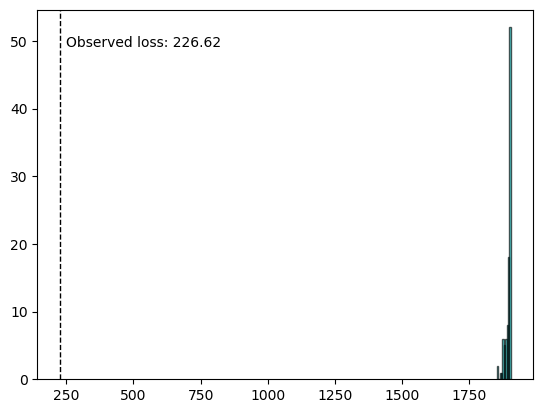

0.009900990099009901


In [125]:
abc, de = Permutation_test(circle_samples_rank_function, extremes_samples_rank_function, 100, plot=True)
print(abc)

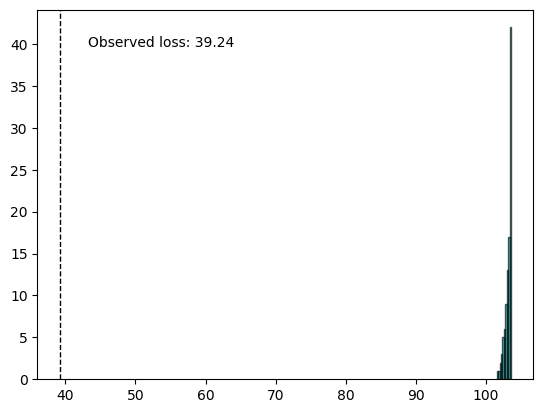

0.009900990099009901


In [127]:
abc, de = Permutation_test(circle_samples_rank_function, centre_samples_rank_function, 100, plot=True)
print(abc)

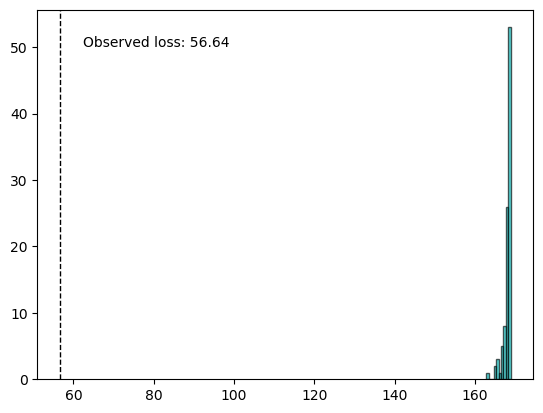

0.009900990099009901


In [128]:
abc, de = Permutation_test(circle_samples_rank_function, noisy_circle_samples_rank_function, 100, plot=True)
print(abc)

## Pairwise comparison of all


[0, 1]


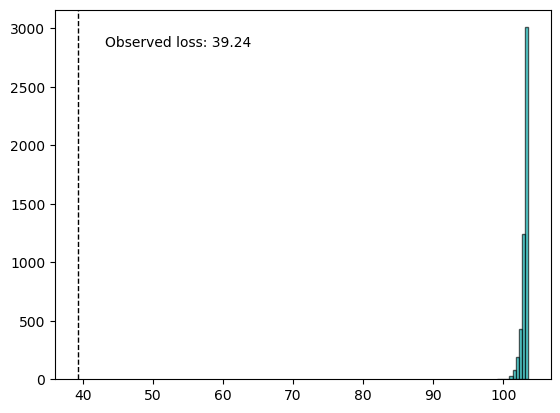

[0, 2]


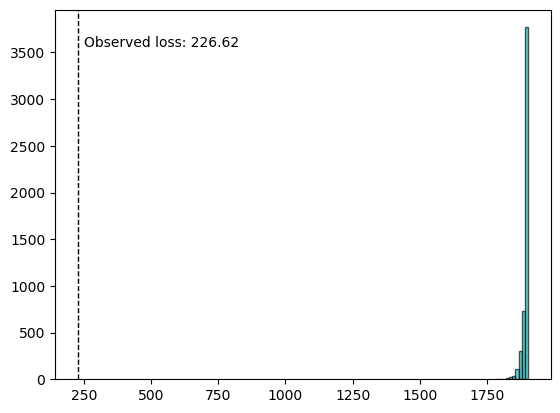

[0, 3]


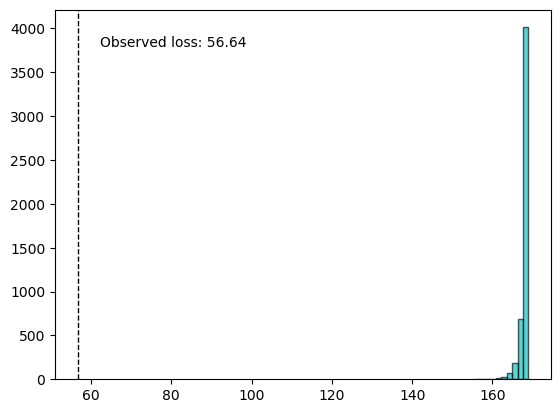

[0, 4]


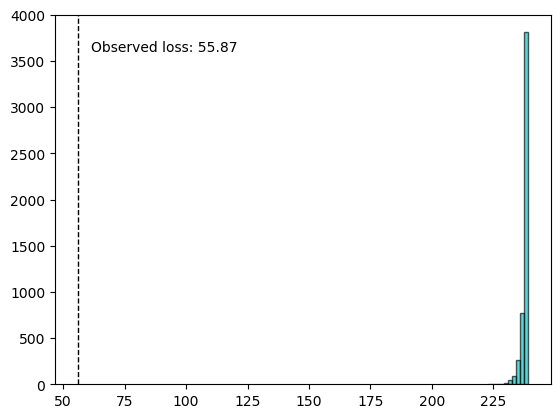

[0, 5]


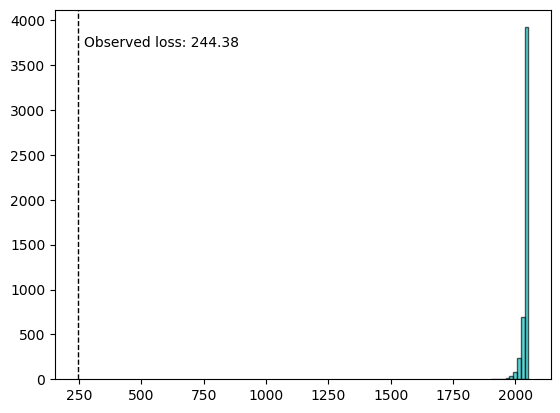

[1, 2]


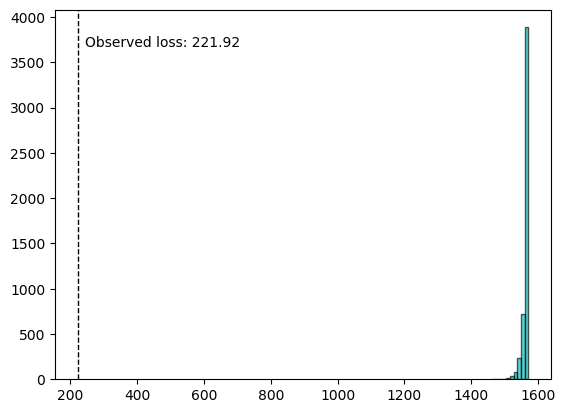

[1, 3]


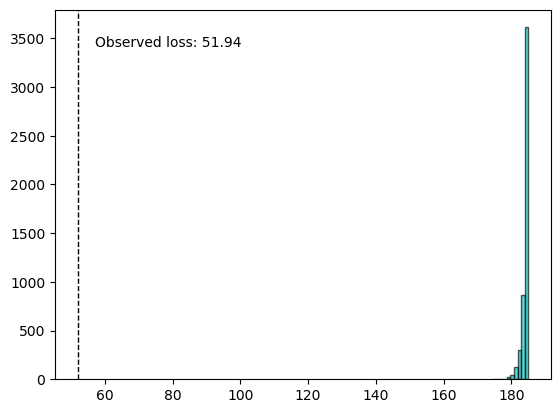

[1, 4]


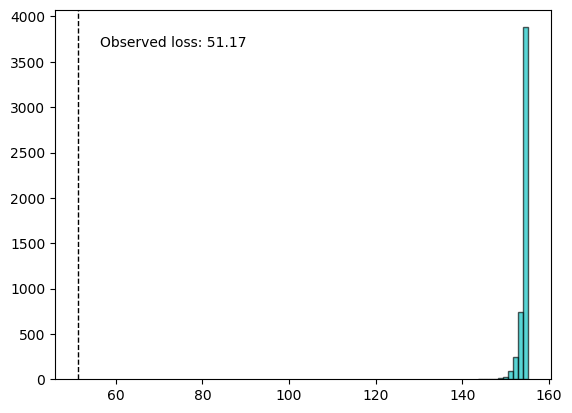

[1, 5]


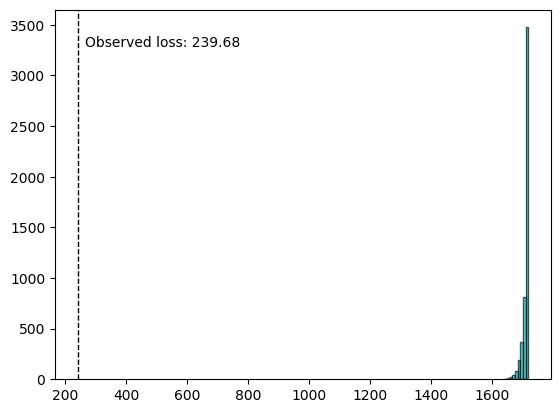

[2, 3]


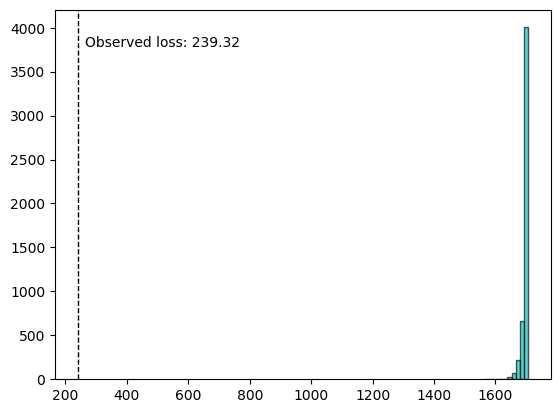

[2, 4]


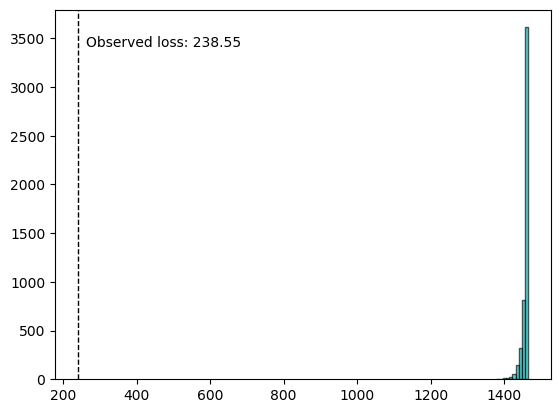

[2, 5]


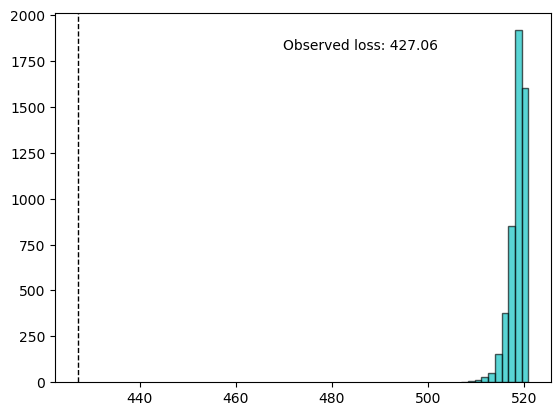

[3, 4]


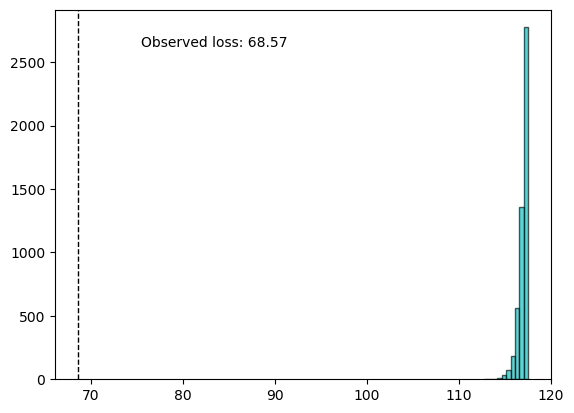

[3, 5]


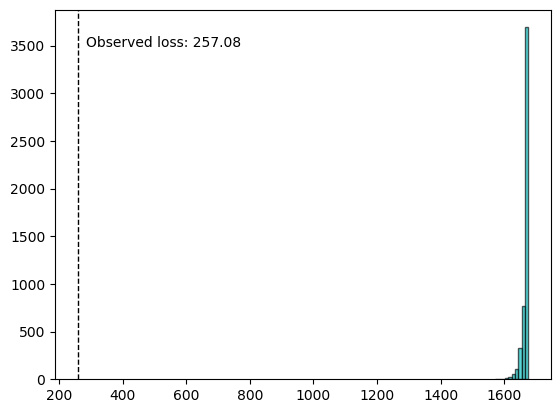

[4, 5]


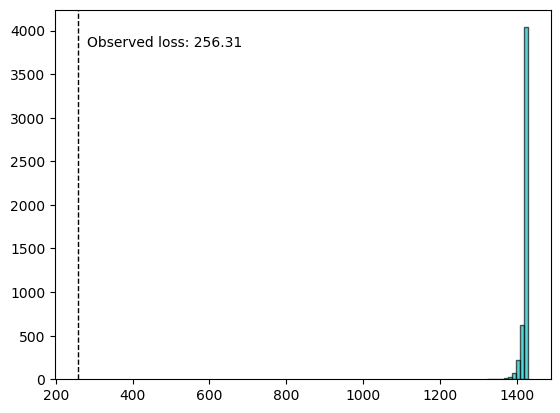

<Figure size 640x480 with 0 Axes>

In [155]:
all_1d_ranks = [circle_samples_rank_function, centre_samples_rank_function, extremes_samples_rank_function, noisy_circle_samples_rank_function, 
noisy_centre_samples_rank_function, noisy_extremes_samples_rank_function]

names = ["circle","centre","extremes","noisycircle","noisycentre","noisyextremes"]

p_vals = np.zeros([6,6])
for i in range(6):
    for j in range(i+1,6):
        print([i,j])
        abc, de = Permutation_test(all_1d_ranks[i], all_1d_ranks[j], 5000, plot=True)
        plt.savefig(names[i]+"_"+names[j]+"1.png")
        p_vals[i,j] = abc


In [156]:
p_vals

array([[0.        , 0.00019996, 0.00019996, 0.00019996, 0.00019996,
        0.00019996],
       [0.        , 0.        , 0.00019996, 0.00019996, 0.00019996,
        0.00019996],
       [0.        , 0.        , 0.        , 0.00019996, 0.00019996,
        0.00019996],
       [0.        , 0.        , 0.        , 0.        , 0.00019996,
        0.00019996],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00019996],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [157]:
np.savetxt("1d_rank_p_vals", p_vals, delimiter=',')

# Compute the degree-rips rank functions

### Names of lists are:
### circle_samples / centre_samples / extremes_samples
### noisy_circle_samples / noisy_centre_samples / noisy_extremes_samples

In [21]:
import os
from rank import rank_function
from helper_functions import Compute_Rivet

In [35]:
# if do not define the function for a point cloud then degree-rips is the default
dim = 0
radius_range=[0,4]

In [36]:
current = Compute_Rivet(trial4, resolution=50, dim=dim, RipsMax=radius_range[1])
small_ranks = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)

In [37]:
small_ranks

array([1., 1., 1., ..., 3., 3., 3.])

In [38]:
max(small_ranks)

25.0

In [39]:
sum(small_ranks)

64805.0

In [32]:
small_ranks.shape

(44100,)

### Compute rank functions for each of the samples for dim=0,1,2

In [43]:
# lists of rank functions dim=0
circle_samples_ranks = [0 for i in range(100)]
centre_samples_ranks = [0 for i in range(100)]
extremes_samples_ranks = [0 for i in range(100)]
noisy_circle_samples_ranks = [0 for i in range(100)]
noisy_centre_samples_ranks = [0 for i in range(100)]
noisy_extremes_samples_ranks = [0 for i in range(100)]

# # lists of rank functions dim=1
# circle_samples_ranks1 = [0 for i in range(100)]
# centre_samples_ranks1 = [0 for i in range(100)]
# extremes_samples_ranks1 = [0 for i in range(100)]
# noisy_circle_samples_ranks1 = [0 for i in range(100)]
# noisy_centre_samples_ranks1 = [0 for i in range(100)]
# noisy_extremes_samples_ranks1 = [0 for i in range(100)]

# # lists of rank functions dim=2
# circle_samples_ranks2 = [0 for i in range(100)]
# centre_samples_ranks2 = [0 for i in range(100)]
# extremes_samples_ranks2 = [0 for i in range(100)]
# noisy_circle_samples_ranks2 = [0 for i in range(100)]
# noisy_centre_samples_ranks2 = [0 for i in range(100)]
# noisy_extremes_samples_ranks2 = [0 for i in range(100)]

for i in range(100):
    # circle_samples
    current = Compute_Rivet(circle_samples[i], resolution=50, dim=0, RipsMax=4)
    circle_samples_ranks[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(circle_samples[i], resolution=50, dim=1, RipsMax=4)
#     circle_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(circle_samples[i], resolution=50, dim=2, RipsMax=4)
#     circle_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # centre_samples
    current = Compute_Rivet(centre_samples[i], resolution=50, dim=0, RipsMax=4)
    centre_samples_ranks[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(centre_samples[i], resolution=50, dim=1, RipsMax=4)
#     centre_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(centre_samples[i], resolution=50, dim=2, RipsMax=4)
#     centre_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # extremes_samples
    current = Compute_Rivet(extremes_samples[i], resolution=50, dim=0, RipsMax=4)
    extremes_samples_ranks[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(extremes_samples[i], resolution=50, dim=1, RipsMax=4)
#     extremes_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(extremes_samples[i], resolution=50, dim=2, RipsMax=4)
#     extremes_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # noisy_circle_samples
    current = Compute_Rivet(noisy_circle_samples[i], resolution=50, dim=0, RipsMax=4)
    noisy_circle_samples_ranks[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(noisy_circle_samples[i], resolution=50, dim=1, RipsMax=4)
#     noisy_circle_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(noisy_circle_samples[i], resolution=50, dim=2, RipsMax=4)
#     noisy_circle_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # noisy_centre_samples
    current = Compute_Rivet(noisy_centre_samples[i], resolution=50, dim=0, RipsMax=4)
    noisy_centre_samples_ranks[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(noisy_centre_samples[i], resolution=50, dim=1, RipsMax=4)
#     noisy_centre_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(noisy_centre_samples[i], resolution=50, dim=2, RipsMax=4)
#     noisy_centre_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # centre_samples
    current = Compute_Rivet(noisy_extremes_samples[i], resolution=50, dim=0, RipsMax=4)
    noisy_extremes_samples_ranks[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(noisy_extremes_samples[i], resolution=50, dim=1, RipsMax=4)
#     noisy_extremes_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(noisy_extremes_samples[i], resolution=50, dim=2, RipsMax=4)
#     noisy_extremes_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    if (i%5==0):
        print(i)







0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [44]:
circle_samples_ranks_array = np.concatenate(circle_samples_ranks, 0)
np.savetxt('circle_samples_ranks_array.csv', circle_samples_ranks_array, delimiter=',') 

noisy_circle_samples_ranks_array = np.concatenate(noisy_circle_samples_ranks, 0)
np.savetxt('noisy_circle_samples_ranks_array.csv', noisy_circle_samples_ranks_array, delimiter=',') 

centre_samples_ranks_array = np.concatenate(centre_samples_ranks, 0)
np.savetxt('centre_samples_ranks_array.csv', centre_samples_ranks_array, delimiter=',') 

noisy_centre_samples_ranks_array = np.concatenate(noisy_centre_samples_ranks, 0)
np.savetxt('noisy_centre_samples_ranks_array.csv', noisy_centre_samples_ranks_array, delimiter=',') 

extremes_samples_ranks_array = np.concatenate(extremes_samples_ranks, 0)
np.savetxt('extremes_samples_ranks_array.csv', extremes_samples_ranks_array, delimiter=',') 

noisy_extremes_samples_ranks_array = np.concatenate(noisy_extremes_samples_ranks, 0)
np.savetxt('noisy_extremes_samples_ranks_array.csv', noisy_extremes_samples_ranks_array, delimiter=',') 



In [45]:


# lists of rank functions dim=1
circle_samples_ranks1 = [0 for i in range(100)]
centre_samples_ranks1 = [0 for i in range(100)]
extremes_samples_ranks1 = [0 for i in range(100)]
noisy_circle_samples_ranks1 = [0 for i in range(100)]
noisy_centre_samples_ranks1 = [0 for i in range(100)]
noisy_extremes_samples_ranks1 = [0 for i in range(100)]

# # lists of rank functions dim=2
# circle_samples_ranks2 = [0 for i in range(100)]
# centre_samples_ranks2 = [0 for i in range(100)]
# extremes_samples_ranks2 = [0 for i in range(100)]
# noisy_circle_samples_ranks2 = [0 for i in range(100)]
# noisy_centre_samples_ranks2 = [0 for i in range(100)]
# noisy_extremes_samples_ranks2 = [0 for i in range(100)]

for i in range(100):
    # circle_samples
    current = Compute_Rivet(circle_samples[i], resolution=50, dim=1, RipsMax=4)
    circle_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(circle_samples[i], resolution=50, dim=2, RipsMax=4)
#     circle_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # centre_samples
    current = Compute_Rivet(centre_samples[i], resolution=50, dim=1, RipsMax=4)
    centre_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(centre_samples[i], resolution=50, dim=2, RipsMax=4)
#     centre_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # extremes_samples
    current = Compute_Rivet(extremes_samples[i], resolution=50, dim=1, RipsMax=4)
    extremes_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(extremes_samples[i], resolution=50, dim=2, RipsMax=4)
#     extremes_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # noisy_circle_samples
    current = Compute_Rivet(noisy_circle_samples[i], resolution=50, dim=1, RipsMax=4)
    noisy_circle_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(noisy_circle_samples[i], resolution=50, dim=2, RipsMax=4)
#     noisy_circle_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # noisy_centre_samples
    current = Compute_Rivet(noisy_centre_samples[i], resolution=50, dim=1, RipsMax=4)
    noisy_centre_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(noisy_centre_samples[i], resolution=50, dim=2, RipsMax=4)
#     noisy_centre_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    # centre_samples
    current = Compute_Rivet(noisy_extremes_samples[i], resolution=50, dim=1, RipsMax=4)
    noisy_extremes_samples_ranks1[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
#     current = Compute_Rivet(noisy_extremes_samples[i], resolution=50, dim=2, RipsMax=4)
#     noisy_extremes_samples_ranks2[i] = rank_function(current, grid_size=20, fixed_bounds=None, use_weights=False, normalize=False, minimum_rank=0)
    
    if (i%5==0):
        print(i)





0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [46]:

circle_samples_ranks1_array = np.concatenate(circle_samples_ranks1, 0)
np.savetxt('circle_samples_ranks1_array.csv', circle_samples_ranks1_array, delimiter=',') 

noisy_circle_samples_ranks1_array = np.concatenate(noisy_circle_samples_ranks1, 0)
np.savetxt('noisy_circle_samples_ranks1_array.csv', noisy_circle_samples_ranks1_array, delimiter=',') 

centre_samples_ranks1_array = np.concatenate(centre_samples_ranks1, 0)
np.savetxt('centre_samples_ranks1_array.csv', centre_samples_ranks1_array, delimiter=',') 

noisy_centre_samples_ranks1_array = np.concatenate(noisy_centre_samples_ranks1, 0)
np.savetxt('noisy_centre_samples_ranks1_array.csv', noisy_centre_samples_ranks1_array, delimiter=',') 

extremes_samples_ranks1_array = np.concatenate(extremes_samples_ranks1, 0)
np.savetxt('extremes_samples_ranks1_array.csv', extremes_samples_ranks1_array, delimiter=',') 

noisy_extremes_samples_ranks1_array = np.concatenate(noisy_extremes_samples_ranks1, 0)
np.savetxt('noisy_extremes_samples_ranks1_array.csv', noisy_extremes_samples_ranks1_array, delimiter=',') 



In [47]:
print("Finished")

Finished


In [ ]:
circle_samples_ranks_array = np.concatenate(circle_samples_ranks, 0)
circle_samples_ranks1_array = np.concatenate(circle_samples_ranks1, 0)
circle_samples_ranks2_array = np.concatenate(circle_samples_ranks2, 0)
np.savetxt('circle_samples_ranks_array.csv', circle_samples_ranks_array, delimiter=',') 
np.savetxt('circle_samples_ranks1_array.csv', circle_samples_ranks1_array, delimiter=',') 
np.savetxt('circle_samples_ranks2_array.csv', circle_samples_ranks2_array, delimiter=',') 

noisy_circle_samples_ranks_array = np.concatenate(noisy_circle_samples_ranks, 0)
noisy_circle_samples_ranks1_array = np.concatenate(noisy_circle_samples_ranks1, 0)
noisy_circle_samples_ranks2_array = np.concatenate(noisy_circle_samples_ranks2, 0)
np.savetxt('noisy_circle_samples_ranks_array.csv', noisy_circle_samples_ranks_array, delimiter=',') 
np.savetxt('noisy_circle_samples_ranks1_array.csv', noisy_circle_samples_ranks1_array, delimiter=',') 
np.savetxt('noisy_circle_samples_ranks2_array.csv', noisy_circle_samples_ranks2_array, delimiter=',') 

centre_samples_ranks_array = np.concatenate(centre_samples_ranks, 0)
centre_samples_ranks1_array = np.concatenate(centre_samples_ranks1, 0)
centre_samples_ranks2_array = np.concatenate(centre_samples_ranks2, 0)
np.savetxt('centre_samples_ranks_array.csv', centre_samples_ranks_array, delimiter=',') 
np.savetxt('centre_samples_ranks1_array.csv', centre_samples_ranks1_array, delimiter=',') 
np.savetxt('centre_samples_ranks2_array.csv', centre_samples_ranks2_array, delimiter=',') 

noisy_centre_samples_ranks_array = np.concatenate(noisy_centre_samples_ranks, 0)
noisy_centre_samples_ranks1_array = np.concatenate(noisy_centre_samples_ranks1, 0)
noisy_centre_samples_ranks2_array = np.concatenate(noisy_centre_samples_ranks2, 0)
np.savetxt('noisy_centre_samples_ranks_array.csv', noisy_centre_samples_ranks_array, delimiter=',') 
np.savetxt('noisy_centre_samples_ranks1_array.csv', noisy_centre_samples_ranks1_array, delimiter=',') 
np.savetxt('noisy_centre_samples_ranks2_array.csv', noisy_centre_samples_ranks2_array, delimiter=',') 

extremes_samples_ranks_array = np.concatenate(extremes_samples_ranks, 0)
extremes_samples_ranks1_array = np.concatenate(extremes_samples_ranks1, 0)
extremes_samples_ranks2_array = np.concatenate(extremes_samples_ranks2, 0)
np.savetxt('extremes_samples_ranks_array.csv', extremes_samples_ranks_array, delimiter=',') 
np.savetxt('extremes_samples_ranks1_array.csv', extremes_samples_ranks1_array, delimiter=',') 
np.savetxt('extremes_samples_ranks2_array.csv', extremes_samples_ranks2_array, delimiter=',') 

noisy_extremes_samples_ranks_array = np.concatenate(noisy_extremes_samples_ranks, 0)
noisy_extremes_samples_ranks1_array = np.concatenate(noisy_extremes_samples_ranks1, 0)
noisy_extremes_samples_ranks2_array = np.concatenate(noisy_extremes_samples_ranks2, 0)
np.savetxt('noisy_extremes_samples_ranks_array.csv', noisy_extremes_samples_ranks_array, delimiter=',') 
np.savetxt('noisy_extremes_samples_ranks1_array.csv', noisy_extremes_samples_ranks1_array, delimiter=',') 
np.savetxt('noisy_extremes_samples_ranks2_array.csv', noisy_extremes_samples_ranks2_array, delimiter=',') 



In [53]:
print([sum(i) for i in circle_samples_ranks])

[44939.0, 44928.0, 45376.0, 45027.0, 45643.0, 45229.0, 44865.0, 44984.0, 45529.0, 45238.0, 45103.0, 44573.0, 44809.0, 45752.0, 45247.0, 45209.0, 45103.0, 44965.0, 45229.0, 45533.0, 44906.0, 44719.0, 45079.0, 45631.0, 46309.0, 47134.0, 45595.0, 45055.0, 45506.0, 44894.0, 46358.0, 45512.0, 45190.0, 45602.0, 45152.0, 45915.0, 44953.0, 44944.0, 44720.0, 44867.0, 45192.0, 45366.0, 45231.0, 45236.0, 45031.0, 44227.0, 45137.0, 46005.0, 45210.0, 44351.0, 45649.0, 45309.0, 44913.0, 44743.0, 45037.0, 45412.0, 45430.0, 45647.0, 45430.0, 44553.0, 44977.0, 44679.0, 45023.0, 46167.0, 44264.0, 45291.0, 45396.0, 44691.0, 44544.0, 45719.0, 45113.0, 44476.0, 44955.0, 45600.0, 45580.0, 44223.0, 45073.0, 45963.0, 45811.0, 44748.0, 45195.0, 45134.0, 45027.0, 46113.0, 45719.0, 46109.0, 44259.0, 44898.0, 45191.0, 44690.0, 45512.0, 44675.0, 44450.0, 45357.0, 44974.0, 45498.0, 44940.0, 45001.0, 45106.0, 46147.0]


only use the 0-dim rank functions

# Setting up permutation tests

## Need to decide on the test statistic:

Options: - mean,  - variance 

( in Robinson and Turner the variance was computed since the mean was expensive to obtain
but here we can use the mean for the rank functions - but what about the idea of greater than or less than for a function - then we may still resort to use the agumented variance )


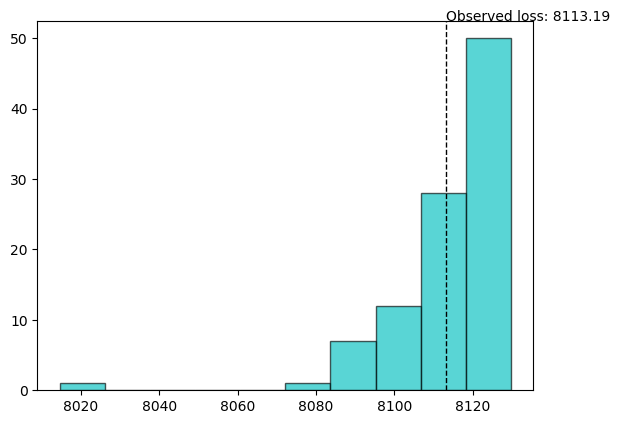

0.31683168316831684


In [165]:
abc, de = Permutation_test(circle_samples_ranks, centre_samples_ranks, 100, plot=True)
print(abc)

[0, 1]


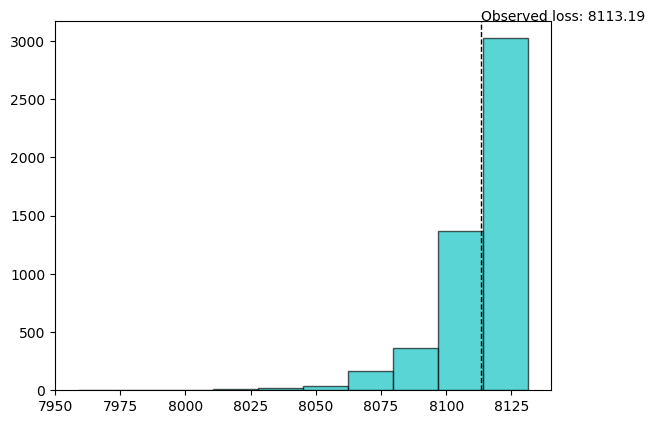

[0, 2]


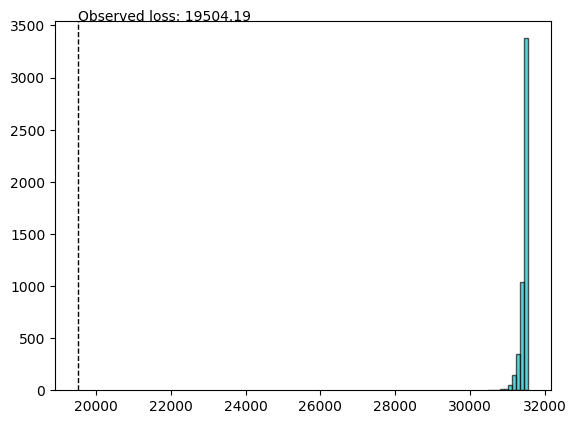

[0, 3]


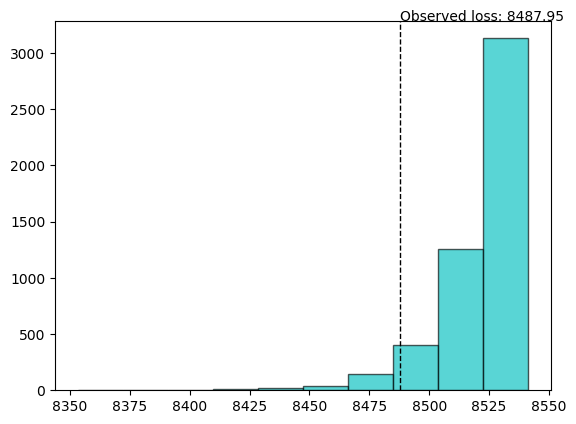

[0, 4]


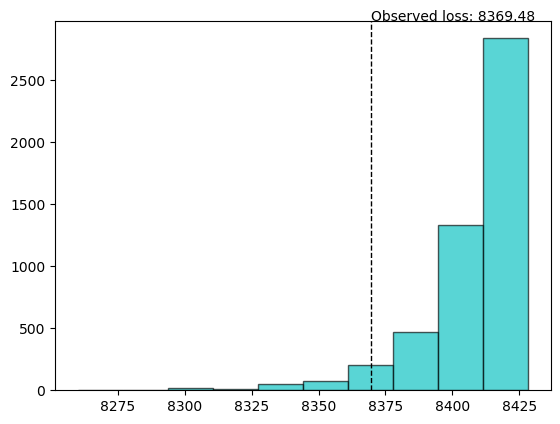

[0, 5]


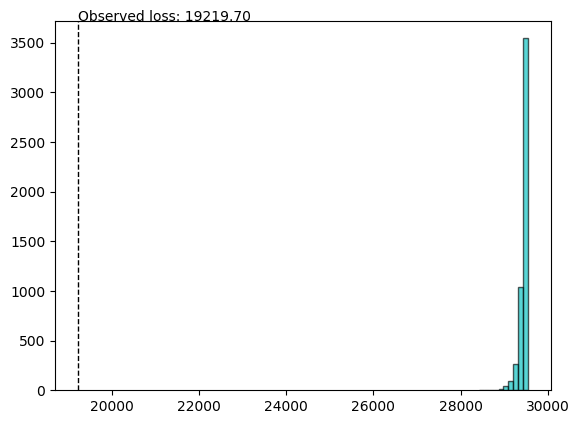

[1, 2]


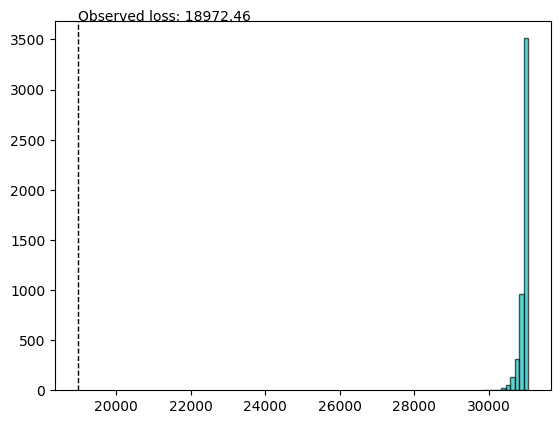

[1, 3]


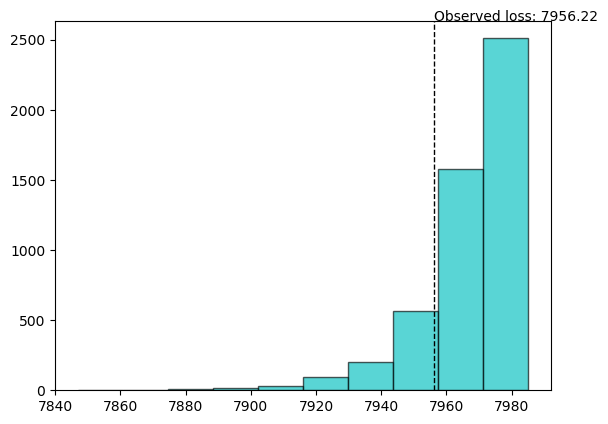

[1, 4]


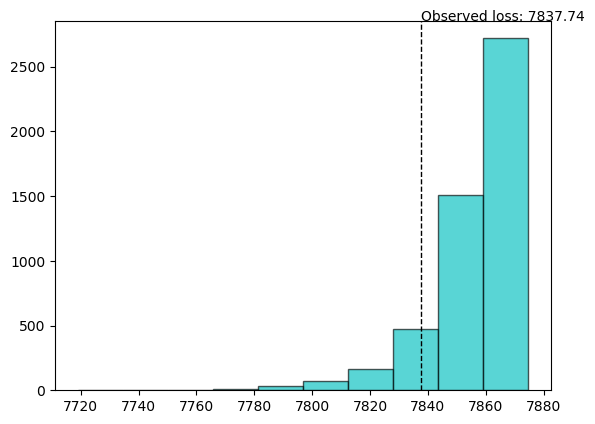

[1, 5]


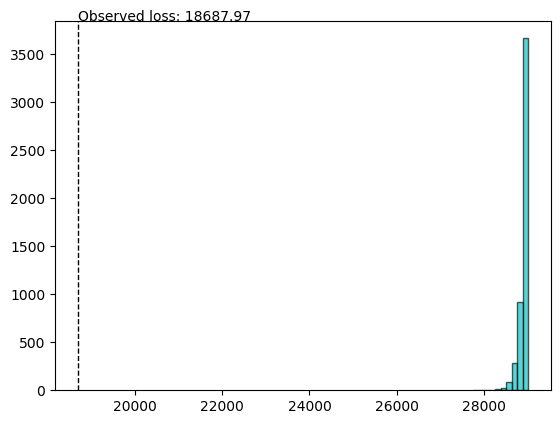

[2, 3]


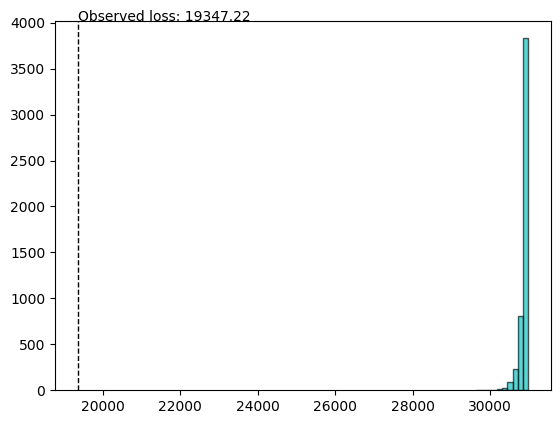

[2, 4]


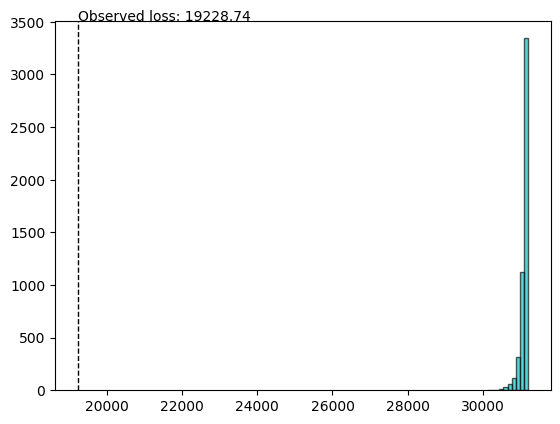

[2, 5]


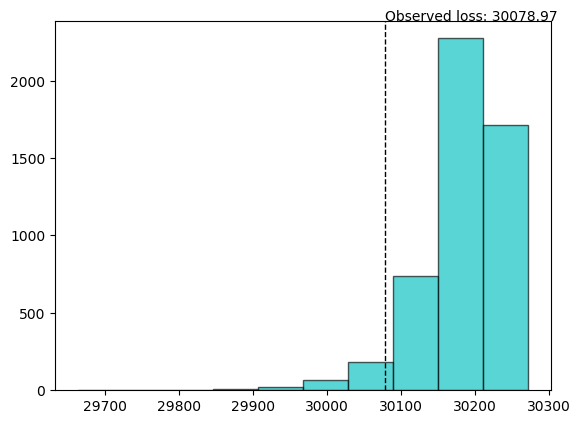

[3, 4]


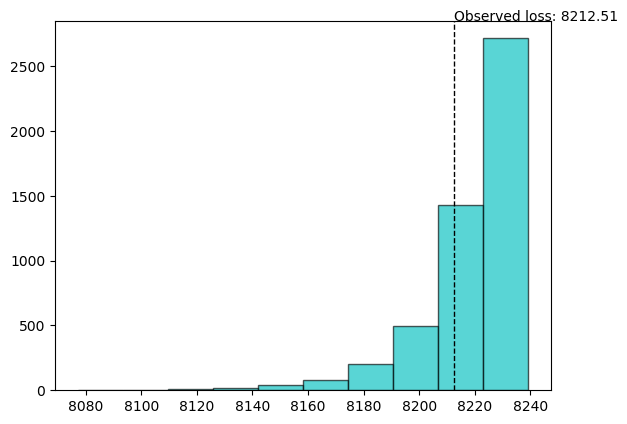

[3, 5]


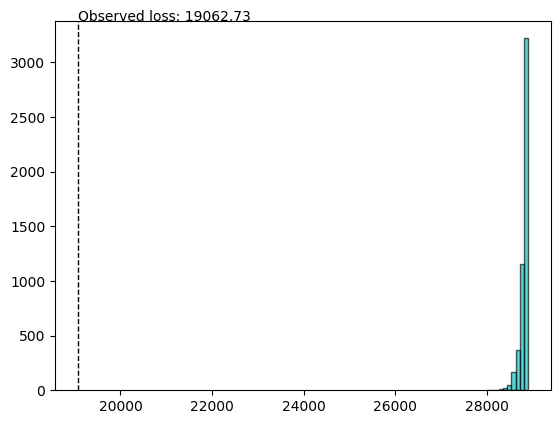

[4, 5]


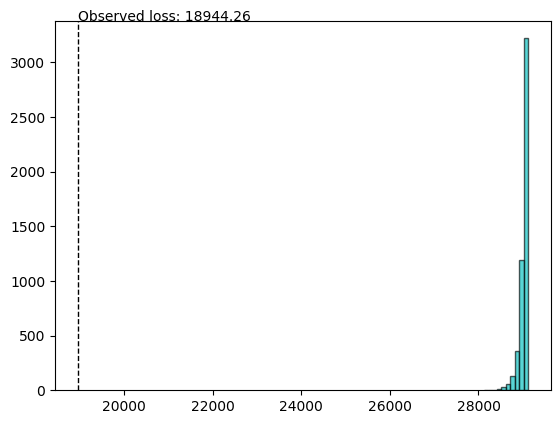

<Figure size 640x480 with 0 Axes>

In [166]:
all_2d_ranks = [circle_samples_ranks, centre_samples_ranks, extremes_samples_ranks,
noisy_circle_samples_ranks, noisy_centre_samples_ranks, noisy_extremes_samples_ranks]
p_vals_2d = np.zeros([6,6])

for i in range(6):
    for j in range(i+1,6):
        print([i,j])
        abc, de = Permutation_test(all_2d_ranks[i], all_2d_ranks[j], 5000, plot=True)
        plt.savefig(names[i]+"_"+names[j]+"2.png")
        p_vals_2d[i,j] = abc


In [167]:
p_vals_2d

array([[0.00000000e+00, 3.65926815e-01, 1.99960008e-04, 5.13897221e-02,
        4.77904419e-02, 1.99960008e-04],
       [0.00000000e+00, 0.00000000e+00, 1.99960008e-04, 1.70365927e-01,
        1.09778044e-01, 1.99960008e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.99960008e-04,
        1.99960008e-04, 4.47910418e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.31953609e-01, 1.99960008e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.99960008e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [168]:
np.savetxt("2d_rank_p_vals", p_vals_2d, delimiter=',')